This is the final version of Project **OasisCoin** after receiving feedback from Dr. Zhang and TA Yi Zhuang on Dec 3, 2025.

**IST 332 FINAL PROJECT - SECTION 2: CORPUS CREATION**

Google News RSS + CoinCompare Price Data + PulseReddit Integration


This script orchestrates data collection from three sources:
1. Google News RSS feeds (news articles)
2. CoinCompare API (historical Bitcoin price data)
3. PulseReddit dataset (Reddit posts/comments, pre-downloaded)

All data is organized, deduplicated, and saved to Google Drive in parquet format.

Ultimately,the whole project, code and data will be made available in github at https://github.com/CGU-AI4Humanity/OasisCoin and it will be made public.

Authors: Prajwal, Varsha, Nihaad, Mahesh
Date: December 2025


In [14]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pandas numpy nltk scikit-learn xgboost textblob requests beautifulsoup4 lxml
!pip install requests beautifulsoup4 lxml pandas

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import sys
import os
sys.path.append('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')

import pandas as pd
import numpy as np
import logging
from pathlib import Path
from datetime import datetime, timedelta
import time
import requests
import json


import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')


import matplotlib.pyplot as plt
import seaborn as sns



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:


# ============================================================================
# SETUP
# ============================================================================

# Import your functions
sys.path.append('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')

print(os.listdir('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/'))

from google_news_functions import get_data as get_google_news_data
from crypto_compare_functions import get_data as get_coincompare_data

# Set base directory for all outputs
from pathlib import Path
BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_PROJECT_FEEDBACK/')

print("✓ Setup complete!")
print(f"✓ Base directory: {BASE_DIR}")
print(f"✓ Directory exists: {BASE_DIR.exists()}")

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
LOG_FILE = BASE_DIR / 'section_2_corpus_creation.log'

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

print("="*80)
print("SECTION 2: CORPUS CREATION")
print("Google News RSS + CoinCompare + PulseReddit")
print("="*80)

['IST 332 Fall 2025 Final Project Group4 - OasisCoin.ipynb', 'google_news_functions.py', 'crypto_compare_functions.py', '__pycache__', 'google_news.log']
✓ Setup complete!
✓ Base directory: /content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_PROJECT_FEEDBACK
✓ Directory exists: False
SECTION 2: CORPUS CREATION
Google News RSS + CoinCompare + PulseReddit


# Section 2: Data Quality Assessment & Corpus Summary Statistics

**Section 2** provides a comprehensive evaluation of the collected data across four sources: Google News, CoinCompare, Reddit Comments, and Binance Prices. The section is divided into two major subsections:

## Data Quality Assessment

Evaluates data completeness, consistency, and integrity for each source:
- **Google News** (20,905 records): 100% complete with no missing values or duplicates. Temporal coverage spans October 2, 2017 to December 7, 2025 (2,988 days). Titles range from 18-237 characters (avg 82 chars).
- **CoinCompare** (5,218 records): 100% complete price data with OHLC (Open-High-Low-Close) values. Price range from $2.05 to $124,723 with stable quality metrics.
- **Reddit Comments** (28,853 records): 7.60% missing values in text fields. Unique author analysis shows community diversity. Contains unhashable data types preventing standard duplicate detection.
- **Binance Prices** (306 daily candles): 100% complete with consistent OHLC data. Covers March-December 2024 at daily granularity.

## Corpus Summary Statistics

Provides aggregate statistics across all data sources:
- **Total corpus**: 55,282 records from 4 sources (Reddit 52.2%, Google News 37.8%, CoinCompare 9.4%, Binance 0.6%)

- **Text volume**: 275,562 words from Google News (avg 13.18 words/title), 1,673,882 words from Reddit (avg 58.01 words/post)

- **Price data**: CoinCompare covers long-term history with mean price $20,868.

  Binance covers recent period (2024) with mean price $69,824

- **Data quality**: Zero missing values in news/price data; 7.6% missing in Reddit; zero duplicates in 3 of 4 sources




In [10]:


# ============================================================================
# 2.1 GOOGLE NEWS DATA
# ============================================================================

logger.info("\n\n" + "="*80)
logger.info("GOOGLE NEWS DATA ACQUISITION")
logger.info("="*80)

# Import Google News functions (from your existing google_news_functions.py)
try:
    from google_news_functions import get_data as get_google_news_data

    logger.info("Fetching Google News data from 2017-10-01 to today...")
    google_news_df = get_google_news_data('2017-10-01')

    logger.info(f"✓ Retrieved {len(google_news_df)} Google News articles")
    logger.info(f"  Columns: {list(google_news_df.columns)}")

    # Save to parquet
    google_news_file = BASE_DIR / 'btc_news_data.parquet.gzip'
    google_news_df.to_parquet(google_news_file, compression='gzip', index=False)
    logger.info(f"✓ Saved to {google_news_file}")

except Exception as e:
    logger.error(f"✗ Error fetching Google News data: {e}")
    google_news_df = None

In [12]:
# ============================================================================
# 2.2 COINCOMPARE PRICE DATA
# ============================================================================

logger.info("\n\n" + "="*80)
logger.info("COINCOMPARE PRICE DATA ACQUISITION")
logger.info("="*80)

# Import CoinCompare functions (from your existing crypto_compare_functions.py)
try:
    from crypto_compare_functions import get_data as get_coincompare_data
    logger.info("Fetching CoinCompare BTC price data...")
    cc_params = {
        'fsym': 'BTC',
        'tsym': 'USD'
    }
    coincompare_df = get_coincompare_data('histoday', cc_params, coin='btc', prefix='cc_')




    logger.info(f"✓ Retrieved {len(coincompare_df)} days of price data")
    logger.info(f"  Columns: {list(coincompare_df.columns)}")
    logger.info(f"  Date range: {coincompare_df.index.min()} to {coincompare_df.index.max()}")

    # Save to parquet
    coincompare_file = BASE_DIR / 'btc_coincompare_data.parquet.gzip'
    coincompare_df.to_parquet(coincompare_file, compression='gzip')
    logger.info(f"✓ Saved to {coincompare_file}")

except Exception as e:
    logger.error(f"✗ Error fetching CoinCompare data: {e}")
    coincompare_df = None

In [14]:
# ============================================================================
# DATA SUMMARY - ADD THIS AT THE END OF CELL 4
# ============================================================================

print("\n" + "="*80)
print("📊 DATA SUMMARY")
print("="*80)

# Reload and inspect files
gn = pd.read_parquet(BASE_DIR / 'btc_news_data.parquet.gzip')
cc = pd.read_parquet(BASE_DIR / 'btc_coincompare_data.parquet.gzip')

# Google News
print(f"\n📰 GOOGLE NEWS")
print(f"   Shape: {gn.shape[0]:,} rows × {gn.shape[1]} columns")
print(f"   Columns: {list(gn.columns)}")
if 'published_date' in gn.columns:
    print(f"   Dates: {gn['published_date'].min()} to {gn['published_date'].max()}")

# CoinCompare
print(f"\n💰 COINCOMPARE")
print(f"   Shape: {cc.shape[0]:,} rows × {cc.shape[1]} columns")
print(f"   Columns: {list(cc.columns)}")
print(f"   Price: ${cc['cc_close'].min():,.2f} - ${cc['cc_close'].max():,.2f}")

from datetime import datetime
first = datetime.fromtimestamp(cc.index.min()).strftime('%Y-%m-%d')
last = datetime.fromtimestamp(cc.index.max()).strftime('%Y-%m-%d')
print(f"   Dates: {first} to {last}")

print(f"\n✅ SECTION 2 COMPLETE")
print(f"   Total records: {len(gn) + len(cc):,}")
print(f"   ➡️  Ready for Section 4")



📊 DATA SUMMARY

📰 GOOGLE NEWS
   Shape: 20,905 rows × 3 columns
   Columns: ['title', 'url', 'datetime']

💰 COINCOMPARE
   Shape: 5,218 rows × 8 columns
   Columns: ['cc_high', 'cc_low', 'cc_open', 'cc_volumefrom', 'cc_volumeto', 'cc_close', 'cc_conversionType', 'cc_conversionSymbol']
   Price: $2.05 - $124,723.00
   Dates: 2011-08-27 to 2025-12-08

✅ SECTION 2 COMPLETE
   Total records: 26,123
   ➡️  Ready for Section 4


In [19]:
# ============================================================================
# SECTION 2.4: PULSEREDDIT DATASET
# ============================================================================

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
OUTPUT_DIR = BASE_DIR

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*80)
print("SECTION 2.4: PULSEREDDIT DATASET")
print("="*80)

# ============================================================================
# 2.4.1 LOAD REDDIT COMMENTS
# ============================================================================

print("\n[1/2] Loading Reddit Bitcoin Comments...")

reddit_comments = []
reddit_file = BASE_DIR / 'data/reddit/bitcoin.jsonl'

try:
    if reddit_file.exists():
        print(f"   Reading {reddit_file}...")
        with open(reddit_file, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    comment = json.loads(line)
                    reddit_comments.append(comment)
                    if line_num % 50000 == 0:
                        print(f"   Loaded {line_num:,} comments...")
                except json.JSONDecodeError:
                    continue

        reddit_df = pd.DataFrame(reddit_comments)
        reddit_parquet = OUTPUT_DIR / 'reddit_comments.parquet.gzip'
        reddit_df.to_parquet(reddit_parquet, compression='gzip', index=False)
        print(f"✅ {len(reddit_df):,} Reddit comments saved")
    else:
        print(f"❌ File not found: {reddit_file}")
        reddit_df = None
except Exception as e:
    print(f"❌ Error loading Reddit  {e}")
    import traceback
    traceback.print_exc()
    reddit_df = None

# ============================================================================
# 2.4.2 LOAD AND AGGREGATE BINANCE PRICES
# ============================================================================

print("\n[2/2] Loading Binance Prices...")

try:
    prices_dir = BASE_DIR / 'data/prices/binance_1h_klines/BTCUSDT'

    if prices_dir.exists():
        csv_files = sorted(prices_dir.glob('*.csv'))
        print(f"   Found {len(csv_files)} price files")

        if csv_files:
            # Load all CSV files
            dfs = []
            for csv_file in csv_files:
                try:
                    # Read without headers
                    df = pd.read_csv(csv_file, header=None)

                    # Check if valid format (at least 6 columns for OHLCV)
                    if len(df.columns) >= 6:
                        # Assign standard column names
                        df.columns = ['time', 'open', 'high', 'low', 'close', 'volume'] + list(df.columns[6:])
                        dfs.append(df)
                        print(f"   Loaded {csv_file.name} ({len(df):,} rows)")
                    else:
                        print(f"   Skipping {csv_file.name} - invalid format")
                except Exception as e:
                    print(f"   Error loading {csv_file.name}: {e}")
                    continue

            if not dfs:
                print(f"❌ No valid price files found!")
                daily = None
            else:
                prices_df = pd.concat(dfs, ignore_index=True).drop_duplicates()
                print(f"   Combined: {len(prices_df):,} total records")

                # Convert timestamp (milliseconds to datetime)
                prices_df['time'] = pd.to_datetime(prices_df['time'], unit='ms', errors='coerce')
                prices_df['date'] = prices_df['time'].dt.date

                # Convert price columns to numeric
                for col in ['open', 'high', 'low', 'close', 'volume']:
                    prices_df[col] = pd.to_numeric(prices_df[col], errors='coerce')

                # Remove rows with NaN dates
                prices_df = prices_df.dropna(subset=['date'])

                # Aggregate to daily OHLC
                daily = prices_df.groupby('date').agg({
                    'open': 'first',
                    'high': 'max',
                    'low': 'min',
                    'close': 'last',
                    'volume': 'sum'
                }).reset_index()

                daily_parquet = OUTPUT_DIR / 'binance_daily_prices.parquet.gzip'
                daily.to_parquet(daily_parquet, compression='gzip', index=False)
                print(f"✅ {len(daily):,} daily prices saved")
                print(f"   Price range: ${daily['close'].min():,.2f} - ${daily['close'].max():,.2f}")
        else:
            print(f"⚠️  No CSV files found in {prices_dir}")
            daily = None
    else:
        print(f"❌ Directory not found: {prices_dir}")
        daily = None

except Exception as e:
    print(f"❌ Error loading prices: {e}")
    import traceback
    traceback.print_exc()
    daily = None

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✅ SECTION 2.4 COMPLETE - PULSEREDDIT DATA")
print("="*80)

if reddit_df is not None:
    print(f"\n📱 Reddit Comments: {len(reddit_df):,}")
else:
    print(f"\n📱 Reddit Comments: 0 (failed to load)")

if 'daily' in locals() and daily is not None:
    print(f"💰 Binance Daily Prices: {len(daily):,}")
else:
    print(f"💰 Binance Daily Prices: 0 (failed to load)")

print(f"\n📁 Output directory: {OUTPUT_DIR}")
print(f"\n✓ All data sources ready!")
print(f"➡️  Next: Section 4 (Text Preprocessing)")


SECTION 2.4: PULSEREDDIT DATASET

[1/2] Loading Reddit Bitcoin Comments...
   Reading /content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/data/reddit/bitcoin.jsonl...
✅ 28,853 Reddit comments saved

[2/2] Loading Binance Prices...
   Found 14 price files
   Loaded BTCUSDT-1h-2024-03.csv (744 rows)
   Loaded BTCUSDT-1h-2024-04.csv (720 rows)
   Loaded BTCUSDT-1h-2024-05.csv (744 rows)
   Loaded BTCUSDT-1h-2024-06.csv (720 rows)
   Loaded BTCUSDT-1h-2024-07.csv (744 rows)
   Loaded BTCUSDT-1h-2024-08.csv (744 rows)
   Loaded BTCUSDT-1h-2024-09.csv (720 rows)
   Loaded BTCUSDT-1h-2024-10.csv (744 rows)
   Loaded BTCUSDT-1h-2024-11.csv (720 rows)
   Loaded BTCUSDT-1h-2024-12.csv (744 rows)
   Loaded BTCUSDT-1h-2025-01.csv (744 rows)
   Loaded BTCUSDT-1h-2025-02.csv (672 rows)
   Loaded BTCUSDT-1h-2025-03.csv (744 rows)
   Loaded BTCUSDT-1h-2025-04.csv (720 rows)
   Combined: 10,224 total records
✅ 306 daily prices saved
   Price range: $53,962.97 - $106,133.74

✅ SECTION 2.4 C

In [25]:

# ============================================================================
# SECTION 2.5: DATA QUALITY ASSESSMENT
# ============================================================================

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
OUTPUT_DIR = BASE_DIR

print("="*80)
print("SECTION 2.5: DATA QUALITY ASSESSMENT")
print("="*80)

print("\n[*] Loading all data files...")

data = {}
data_files = {
    'Google News': OUTPUT_DIR / 'btc_news_data.parquet.gzip',
    'CoinCompare': OUTPUT_DIR / 'btc_coincompare_data.parquet.gzip',
    'Reddit Comments': OUTPUT_DIR / 'reddit_comments.parquet.gzip',
    'Binance Prices': OUTPUT_DIR / 'binance_daily_prices.parquet.gzip'
}

for source_name, filepath in data_files.items():
    try:
        if os.path.exists(filepath):
            data[source_name] = pd.read_parquet(filepath)
            print(f"OK {source_name}: {len(data[source_name]):,} records")
        else:
            print(f"NOT FOUND {source_name}: {filepath}")
    except Exception as e:
        print(f"ERROR {source_name}: {e}")

print("\n" + "="*80)
print("2.5.1 GOOGLE NEWS DATA QUALITY")
print("="*80)

file_key = 'Google News'
if os.path.exists(data_files[file_key]):
    df = data[file_key]

    print(f"\nSHAPE AND SIZE")
    print(f"   Rows: {len(df):,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

    print(f"\nCOLUMNS")
    for idx, col in enumerate(df.columns, 1):
        print(f"   {idx}. {col} ({df[col].dtype})")

    print(f"\nCOMPLETENESS")
    missing = df.isnull().sum()
    for col in df.columns:
        missing_count = missing[col]
        missing_pct = (missing_count / len(df)) * 100
        status = "OK" if missing_count == 0 else "WARN"
        print(f"   {status} {col}: {missing_count:,} missing ({missing_pct:.2f}%)")

    print(f"\nTEMPORAL COVERAGE")
    if 'published_date' in df.columns:
        first_date = df['published_date'].min()
        last_date = df['published_date'].max()
        date_span = (pd.to_datetime(last_date) - pd.to_datetime(first_date)).days
        print(f"   First: {first_date}")
        print(f"   Last: {last_date}")
        print(f"   Span: {date_span} days")

    print(f"\nDUPLICATES")
    dup_count = len(df) - len(df.drop_duplicates())
    dup_pct = (dup_count / len(df)) * 100
    print(f"   Total: {dup_count:,} ({dup_pct:.2f}%)")

    print(f"\nTEXT QUALITY")
    if 'title' in df.columns:
        title_lens = df['title'].str.len()
        print(f"   Title - Min: {title_lens.min()}, Max: {title_lens.max()}, Mean: {title_lens.mean():.0f}")
    if 'description' in df.columns:
        desc_lens = df['description'].str.len()
        print(f"   Desc - Min: {desc_lens.min()}, Max: {desc_lens.max()}, Mean: {desc_lens.mean():.0f}")
else:
    print(f"\nNOT LOADED: {data_files[file_key]}")

print("\n" + "="*80)
print("2.5.2 COINCOMPARE DATA QUALITY")
print("="*80)

file_key = 'CoinCompare'
if os.path.exists(data_files[file_key]):
    df = data[file_key]

    print(f"\nSHAPE AND SIZE")
    print(f"   Rows: {len(df):,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

    print(f"\nCOLUMNS")
    for idx, col in enumerate(df.columns, 1):
        print(f"   {idx}. {col} ({df[col].dtype})")

    print(f"\nCOMPLETENESS")
    missing = df.isnull().sum()
    for col in df.columns:
        missing_count = missing[col]
        missing_pct = (missing_count / len(df)) * 100
        status = "OK" if missing_count == 0 else "WARN"
        print(f"   {status} {col}: {missing_count:,} missing ({missing_pct:.2f}%)")

    print(f"\nPRICE STATISTICS")
    if 'cc_close' in df.columns:
        close = df['cc_close']
        print(f"   Min: {close.min():,.2f}")
        print(f"   Max: {close.max():,.2f}")
        print(f"   Mean: {close.mean():,.2f}")
        print(f"   Median: {close.median():,.2f}")
        print(f"   Std Dev: {close.std():,.2f}")

    print(f"\nDUPLICATES")
    dup_count = len(df) - len(df.drop_duplicates())
    dup_pct = (dup_count / len(df)) * 100
    print(f"   Total: {dup_count:,} ({dup_pct:.2f}%)")
else:
    print(f"\nNOT LOADED: {data_files[file_key]}")

print("\n" + "="*80)
print("2.5.3 REDDIT COMMENTS DATA QUALITY")
print("="*80)

file_key = 'Reddit Comments'
if os.path.exists(data_files[file_key]):
    df = data[file_key]

    print(f"\nSHAPE AND SIZE")
    print(f"   Rows: {len(df):,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

    print(f"\nCOLUMNS (first 10)")
    for idx, col in enumerate(df.columns[:10], 1):
        print(f"   {idx}. {col} ({df[col].dtype})")
    if len(df.columns) > 10:
        print(f"   and {len(df.columns) - 10} more")

    print(f"\nCOMPLETENESS")
    missing = df.isnull().sum()
    missing_cols = missing[missing > 0].sort_values(ascending=False)
    if len(missing_cols) > 0:
        for col in missing_cols.index:
            missing_count = missing[col]
            missing_pct = (missing_count / len(df)) * 100
            print(f"   WARN {col}: {missing_count:,} missing ({missing_pct:.2f}%)")
    else:
        print(f"   OK No missing values")

    print(f"\nCOMMENT TEXT")
    text_cols = [c for c in df.columns if any(x in c.lower() for x in ['body', 'text', 'comment', 'selftext'])]
    if text_cols:
        text_col = text_cols[0]
        text_lens = df[text_col].astype(str).str.len()
        non_empty = (text_lens > 0).sum()
        non_empty_pct = (non_empty / len(df)) * 100
        print(f"   Column: {text_col}")
        print(f"   Length - Min: {text_lens.min()}, Max: {text_lens.max()}, Mean: {text_lens.mean():.0f}")
        print(f"   Non-empty: {non_empty:,} ({non_empty_pct:.1f}%)")

    print(f"\nUNIQUE AUTHORS")
    if 'author' in df.columns:
        unique_authors = df['author'].nunique()
        avg_per_author = len(df) / unique_authors
        print(f"   Total: {unique_authors:,}")
        print(f"   Avg per author: {avg_per_author:.1f}")
        print(f"   Top 5:")
        for author, count in df['author'].value_counts().head(5).items():
            print(f"      {author}: {count:,}")

    print(f"\nDUPLICATES")
    try:
        dup_count = len(df) - len(df.drop_duplicates())
        dup_pct = (dup_count / len(df)) * 100
        print(f"   Total: {dup_count:,} ({dup_pct:.2f}%)")
    except TypeError:
        print(f"   Unable to check: contains unhashable types (arrays)")
else:
    print(f"\nNOT LOADED: {data_files[file_key]}")

print("\n" + "="*80)
print("2.5.4 BINANCE PRICES DATA QUALITY")
print("="*80)

file_key = 'Binance Prices'
if os.path.exists(data_files[file_key]):
    df = data[file_key]

    print(f"\nSHAPE AND SIZE")
    print(f"   Rows: {len(df):,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

    print(f"\nCOLUMNS")
    for idx, col in enumerate(df.columns, 1):
        print(f"   {idx}. {col} ({df[col].dtype})")

    print(f"\nCOMPLETENESS")
    missing = df.isnull().sum()
    for col in df.columns:
        missing_count = missing[col]
        missing_pct = (missing_count / len(df)) * 100
        status = "OK" if missing_count == 0 else "WARN"
        print(f"   {status} {col}: {missing_count:,} missing ({missing_pct:.2f}%)")

    print(f"\nPRICE STATISTICS")
    for col in ['open', 'high', 'low', 'close']:
        if col in df.columns:
            col_data = df[col]
            print(f"   {col.upper()}: Min={col_data.min():,.2f}, Max={col_data.max():,.2f}, Mean={col_data.mean():,.2f}")

    print(f"\nOHLC CONSISTENCY")
    if all(c in df.columns for c in ['open', 'high', 'low', 'close']):
        bad_count = (
            (df['high'] < df['low']).sum() +
            (df['open'] > df['high']).sum() +
            (df['open'] < df['low']).sum() +
            (df['close'] > df['high']).sum() +
            (df['close'] < df['low']).sum()
        )
        bad_pct = (bad_count / len(df)) * 100
        print(f"   Invalid: {bad_count:,} ({bad_pct:.2f}%)")
        if bad_count == 0:
            print(f"   OK All OHLC consistent")

    print(f"\nTEMPORAL COVERAGE")
    if 'date' in df.columns:
        first = df['date'].min()
        last = df['date'].max()
        span = (last - first).days
        print(f"   First: {first}")
        print(f"   Last: {last}")
        print(f"   Span: {span} days")

    print(f"\nDUPLICATES")
    dup_count = len(df) - len(df.drop_duplicates())
    dup_pct = (dup_count / len(df)) * 100
    print(f"   Total: {dup_count:,} ({dup_pct:.2f}%)")
else:
    print(f"\nNOT LOADED: {data_files[file_key]}")

print("\n" + "="*80)
print("2.5.5 CROSS-SOURCE ANALYSIS")
print("="*80)

total_records = sum(len(data[key]) for key in data)
print(f"\nCOMBINED CORPUS")
print(f"   Total records: {total_records:,}")

print(f"\nRECORD DISTRIBUTION")
for source in ['Google News', 'CoinCompare', 'Reddit Comments', 'Binance Prices']:
    if os.path.exists(data_files[source]):
        count = len(data[source])
        pct = (count / total_records) * 100
        print(f"   {source}: {count:,} ({pct:.1f}%)")

print("\n" + "="*80)
print("SECTION 2.5 COMPLETE - DATA QUALITY SUMMARY")
print("="*80)

print(f"\nOK DATA SOURCES LOADED: {len(data)}/4")
print(f"OK TOTAL RECORDS: {total_records:,}")
print(f"\nData quality assessment complete")
print(f"Ready for Section 4 (Text Preprocessing)")


SECTION 2.5: DATA QUALITY ASSESSMENT

[*] Loading all data files...
OK Google News: 20,905 records
OK CoinCompare: 5,218 records
OK Reddit Comments: 28,853 records
OK Binance Prices: 306 records

2.5.1 GOOGLE NEWS DATA QUALITY

SHAPE AND SIZE
   Rows: 20,905
   Columns: 3
   Memory: 10.38 MB

COLUMNS
   1. title (object)
   2. url (object)
   3. datetime (datetime64[ns])

COMPLETENESS
   OK title: 0 missing (0.00%)
   OK url: 0 missing (0.00%)
   OK datetime: 0 missing (0.00%)

TEMPORAL COVERAGE

DUPLICATES
   Total: 0 (0.00%)

TEXT QUALITY
   Title - Min: 18, Max: 237, Mean: 82

2.5.2 COINCOMPARE DATA QUALITY

SHAPE AND SIZE
   Rows: 5,218
   Columns: 8
   Memory: 0.80 MB

COLUMNS
   1. cc_high (float64)
   2. cc_low (float64)
   3. cc_open (float64)
   4. cc_volumefrom (float64)
   5. cc_volumeto (float64)
   6. cc_close (float64)
   7. cc_conversionType (object)
   8. cc_conversionSymbol (object)

COMPLETENESS
   OK cc_high: 0 missing (0.00%)
   OK cc_low: 0 missing (0.00%)
   OK cc

In [26]:

# ============================================================================
# SECTION 2.6: CORPUS SUMMARY STATISTICS
# ============================================================================

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
OUTPUT_DIR = BASE_DIR

print("="*80)
print("SECTION 2.6: CORPUS SUMMARY STATISTICS")
print("="*80)

print("\n[*] Loading all data files...")

data = {}
data_files = {
    'Google News': OUTPUT_DIR / 'btc_news_data.parquet.gzip',
    'CoinCompare': OUTPUT_DIR / 'btc_coincompare_data.parquet.gzip',
    'Reddit Comments': OUTPUT_DIR / 'reddit_comments.parquet.gzip',
    'Binance Prices': OUTPUT_DIR / 'binance_daily_prices.parquet.gzip'
}

for source_name, filepath in data_files.items():
    try:
        if os.path.exists(filepath):
            data[source_name] = pd.read_parquet(filepath)
            print(f"OK {source_name}: {len(data[source_name]):,} records")
        else:
            print(f"NOT FOUND {source_name}: {filepath}")
    except Exception as e:
        print(f"ERROR {source_name}: {e}")

print("\n" + "="*80)
print("2.6.1 OVERALL CORPUS STATISTICS")
print("="*80)

total_records = sum(len(data[key]) for key in data)
print(f"\nTOTAL RECORDS ACROSS ALL SOURCES")
print(f"   Total: {total_records:,}")
print(f"   Sources: {len(data)}")

print(f"\nRECORD DISTRIBUTION BY SOURCE")
source_stats = {}
for source in ['Google News', 'CoinCompare', 'Reddit Comments', 'Binance Prices']:
    if os.path.exists(data_files[source]):
        count = len(data[source])
        pct = (count / total_records) * 100
        source_stats[source] = count
        print(f"   {source}: {count:,} ({pct:.1f}%)")

print(f"\nTEMPORAL SPAN")
all_dates = []

if os.path.exists(data_files['Google News']):
    df_news = data['Google News']
    if 'datetime' in df_news.columns:
        all_dates.extend(pd.to_datetime(df_news['datetime']))
        min_news = df_news['datetime'].min()
        max_news = df_news['datetime'].max()
        print(f"   Google News: {min_news} to {max_news}")

if os.path.exists(data_files['Binance Prices']):
    df_binance = data['Binance Prices']
    if 'date' in df_binance.columns:
        all_dates.extend(pd.to_datetime(df_binance['date']))
        min_binance = df_binance['date'].min()
        max_binance = df_binance['date'].max()
        print(f"   Binance Prices: {min_binance} to {max_binance}")

if all_dates:
    overall_min = min(all_dates)
    overall_max = max(all_dates)
    span_days = (overall_max - overall_min).days
    print(f"   Overall Span: {span_days:,} days")

print("\n" + "="*80)
print("2.6.2 TEXT DATA STATISTICS")
print("="*80)

print(f"\nGOOGLE NEWS TEXT CORPUS")
if os.path.exists(data_files['Google News']):
    df_news = data['Google News']

    if 'title' in df_news.columns:
        titles = df_news['title'].astype(str)
        total_words = titles.str.split().str.len().sum()
        total_chars = titles.str.len().sum()
        avg_words = total_words / len(df_news)
        avg_chars = total_chars / len(df_news)

        print(f"   Articles: {len(df_news):,}")
        print(f"   Total Words (Titles): {total_words:,}")
        print(f"   Total Characters (Titles): {total_chars:,}")
        print(f"   Avg Words per Title: {avg_words:.2f}")
        print(f"   Avg Characters per Title: {avg_chars:.2f}")

print(f"\nREDDIT COMMENTS TEXT CORPUS")
if os.path.exists(data_files['Reddit Comments']):
    df_reddit = data['Reddit Comments']

    text_cols = [c for c in df_reddit.columns if any(x in c.lower() for x in ['body', 'text', 'comment', 'selftext'])]

    if text_cols:
        text_col = text_cols[0]
        texts = df_reddit[text_col].astype(str)

        total_words = texts.str.split().str.len().sum()
        total_chars = texts.str.len().sum()
        avg_words = total_words / len(df_reddit)
        avg_chars = total_chars / len(df_reddit)

        print(f"   Posts/Comments: {len(df_reddit):,}")
        print(f"   Total Words: {total_words:,}")
        print(f"   Total Characters: {total_chars:,}")
        print(f"   Avg Words per Post: {avg_words:.2f}")
        print(f"   Avg Characters per Post: {avg_chars:.2f}")

print("\n" + "="*80)
print("2.6.3 PRICE DATA STATISTICS")
print("="*80)

print(f"\nCOINCOMPARE PRICE DATA")
if os.path.exists(data_files['CoinCompare']):
    df_cc = data['CoinCompare']

    price_cols = ['cc_open', 'cc_high', 'cc_low', 'cc_close']

    print(f"   Records: {len(df_cc):,}")

    for col in price_cols:
        if col in df_cc.columns:
            col_data = df_cc[col]
            print(f"   {col}:")
            print(f"      Min: ${col_data.min():,.2f}")
            print(f"      Max: ${col_data.max():,.2f}")
            print(f"      Mean: ${col_data.mean():,.2f}")
            print(f"      Median: ${col_data.median():,.2f}")
            print(f"      Std Dev: ${col_data.std():,.2f}")

print(f"\nBINANCE PRICE DATA")
if os.path.exists(data_files['Binance Prices']):
    df_binance = data['Binance Prices']

    price_cols = ['open', 'high', 'low', 'close']

    print(f"   Daily Candles: {len(df_binance):,}")

    for col in price_cols:
        if col in df_binance.columns:
            col_data = df_binance[col]
            print(f"   {col}:")
            print(f"      Min: ${col_data.min():,.2f}")
            print(f"      Max: ${col_data.max():,.2f}")
            print(f"      Mean: ${col_data.mean():,.2f}")
            print(f"      Median: ${col_data.median():,.2f}")
            print(f"      Std Dev: ${col_data.std():,.2f}")

print("\n" + "="*80)
print("2.6.4 DATA QUALITY SUMMARY")
print("="*80)

print(f"\nMISSING VALUES SUMMARY")

for source in ['Google News', 'CoinCompare', 'Reddit Comments', 'Binance Prices']:
    if os.path.exists(data_files[source]):
        df = data[source]
        total_cells = len(df) * len(df.columns)
        missing_cells = df.isnull().sum().sum()
        missing_pct = (missing_cells / total_cells) * 100

        print(f"   {source}:")
        print(f"      Missing cells: {missing_cells:,} ({missing_pct:.2f}%)")

print(f"\nDUPLICATES SUMMARY")

for source in ['Google News', 'CoinCompare', 'Reddit Comments', 'Binance Prices']:
    if os.path.exists(data_files[source]):
        df = data[source]

        if source == 'Reddit Comments':
            try:
                dup_count = len(df) - len(df.drop_duplicates())
                dup_pct = (dup_count / len(df)) * 100
                print(f"   {source}: {dup_count:,} ({dup_pct:.2f}%)")
            except TypeError:
                print(f"   {source}: Unable to check (unhashable types)")
        else:
            dup_count = len(df) - len(df.drop_duplicates())
            dup_pct = (dup_count / len(df)) * 100
            print(f"   {source}: {dup_count:,} ({dup_pct:.2f}%)")

print("\n" + "="*80)
print("2.6.5 DATA VOLUME SUMMARY TABLE")
print("="*80)

summary_table = []

for source in ['Google News', 'CoinCompare', 'Reddit Comments', 'Binance Prices']:
    if os.path.exists(data_files[source]):
        df = data[source]
        summary_table.append({
            'Source': source,
            'Records': len(df),
            'Columns': len(df.columns),
            'Memory (MB)': df.memory_usage(deep=True).sum() / 1024 / 1024
        })

summary_df = pd.DataFrame(summary_table)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*80)
print("SECTION 2.6 COMPLETE - CORPUS SUMMARY STATISTICS")
print("="*80)

print(f"\nOVERALL SUMMARY")
print(f"   Total Records: {total_records:,}")
print(f"   Data Sources: {len(data)}")
print(f"   Total Memory: {sum(len(data[key]) * len(data[key].columns) for key in data) / 1024 / 1024:.2f} MB")
print(f"\nCorpus summary statistics complete")
print(f"Ready for Section 4 (Text Preprocessing)")


SECTION 2.6: CORPUS SUMMARY STATISTICS

[*] Loading all data files...
OK Google News: 20,905 records
OK CoinCompare: 5,218 records
OK Reddit Comments: 28,853 records
OK Binance Prices: 306 records

2.6.1 OVERALL CORPUS STATISTICS

TOTAL RECORDS ACROSS ALL SOURCES
   Total: 55,282
   Sources: 4

RECORD DISTRIBUTION BY SOURCE
   Google News: 20,905 (37.8%)
   CoinCompare: 5,218 (9.4%)
   Reddit Comments: 28,853 (52.2%)
   Binance Prices: 306 (0.6%)

TEMPORAL SPAN
   Google News: 2017-10-02 07:00:00 to 2025-12-07 20:36:38
   Binance Prices: 2024-03-01 to 2024-12-31
   Overall Span: 2,988 days

2.6.2 TEXT DATA STATISTICS

GOOGLE NEWS TEXT CORPUS
   Articles: 20,905
   Total Words (Titles): 275,562
   Total Characters (Titles): 1,717,700
   Avg Words per Title: 13.18
   Avg Characters per Title: 82.17

REDDIT COMMENTS TEXT CORPUS
   Posts/Comments: 28,853
   Total Words: 1,673,882
   Total Characters: 9,836,273
   Avg Words per Post: 58.01
   Avg Characters per Post: 340.91

2.6.3 PRICE DAT

# Section 3: Text Preprocessing - Summary

**Section 3** implements a comprehensive text preprocessing pipeline designed for financial news and social media text analysis. The section includes six sequential stages:

1. **Basic Text Cleaning & Lowercasing** - Removes URLs, HTML tags, formatting noise, and converts all text to lowercase for consistency.

2. **Tokenization** - Splits cleaned text into individual word tokens using NLTK's word_tokenize function.

3. **Punctuation Removal** - Filters out pure punctuation tokens that don't carry semantic meaning.

4. **Domain-Aware Stopword Removal** - Removes common English stopwords while preserving crypto-specific and sentiment-bearing terms (e.g., "bitcoin", "bullish", "crash", "pump") that are critical for financial text analysis.

5. **Lemmatization** - Reduces inflected words to their base forms (e.g., "buying", "bought", "buys" → "buy") to reduce feature sparsity and improve model generalization.

6. **Token Statistics** - Tracks reduction metrics (token count, character count, reduction percentage) for quality assurance.

The pipeline is applied to both **Google News articles** (20,905 records with titles) and **Reddit posts** (28,853 records with comment text). Results show approximately 25-30% token reduction after preprocessing, with domain-specific terminology preserved. Examples of raw vs. processed text transformations demonstrate the effectiveness of the pipeline in maintaining semantic meaning while removing noise.



In [18]:

# ============================================================================
# SECTION 3: TEXT PREPROCESSING
# ============================================================================

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
OUTPUT_DIR = BASE_DIR

print("="*80)
print("SECTION 3: TEXT PREPROCESSING")
print("="*80)

print("\n[*] Loading all data files...")

data = {}
data_files = {
    'Google News': OUTPUT_DIR / 'btc_news_data.parquet.gzip',
    'Reddit Comments': OUTPUT_DIR / 'reddit_comments.parquet.gzip'
}

for source_name, filepath in data_files.items():
    try:
        if os.path.exists(filepath):
            data[source_name] = pd.read_parquet(filepath)
            print(f"OK {source_name}: {len(data[source_name]):,} records")
        else:
            print(f"NOT FOUND {source_name}")
    except Exception as e:
        print(f"ERROR {source_name}: {e}")

print("\n" + "="*80)
print("3.1 PREPROCESSING PIPELINE DEFINITION")
print("="*80)

# Domain-specific stopwords to PRESERVE
CRYPTO_PRESERVE = {
    'bitcoin', 'btc', 'crypto', 'cryptocurrency', 'ethereum', 'eth',
    'bull', 'bear', 'bullish', 'bearish', 'hodl', 'buy', 'sell',
    'long', 'short', 'crash', 'surge', 'plunge', 'rally', 'pump', 'dump',
    'good', 'bad', 'up', 'down', 'high', 'low', 'not', 'no', 'cannot'
}

# Get standard English stopwords
ENGLISH_STOPWORDS = set(stopwords.words('english'))

# Remove crypto terms from stopwords
CUSTOM_STOPWORDS = ENGLISH_STOPWORDS - CRYPTO_PRESERVE

print(f"\nSTOPWORD CONFIGURATION")
print(f"   Standard English stopwords: {len(ENGLISH_STOPWORDS)}")
print(f"   Crypto-specific terms preserved: {len(CRYPTO_PRESERVE)}")
print(f"   Final custom stopwords: {len(CUSTOM_STOPWORDS)}")

def clean_text(text):
    """Stage 1-2: Basic cleaning and lowercasing"""
    if pd.isna(text):
        return ""

    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\n', ' ', text)

    return text.strip()

def tokenize_text(text):
    """Stage 3: Tokenization"""
    if not text:
        return []
    return word_tokenize(text)

def preprocessing(tokens):
    """Stage 4-7: Comprehensive preprocessing with domain preservation"""
    # Lowercase (ensure consistency)
    tokens = [token.lower() for token in tokens]

    # Remove pure digit tokens
    tokens = [token for token in tokens if not token.isdigit()]

    # Remove tokens that are only punctuation
    tokens = [token for token in tokens if not all(c in string.punctuation for c in token)]

    # Remove tokens that are only non-word characters
    tokens = [t for t in tokens if not re.fullmatch(r"[^\w]+", t)]

    # Remove stopwords (with crypto exceptions)
    tokens = [token for token in tokens if token not in CUSTOM_STOPWORDS]

    # Remove short words (length <= 2 characters)
    tokens = [word for word in tokens if len(word) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

def preprocess_pipeline(text):
    """Complete preprocessing pipeline"""
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    tokens = preprocessing(tokens)
    return tokens

print(f"\nPIPELINE STAGES DEFINED")
print(f"   Stage 1-2: clean_text() - URLs, HTML, formatting, lowercase")
print(f"   Stage 3: tokenize_text() - Word tokenization")
print(f"   Stage 4-7: preprocessing() - Multi-stage cleaning:")
print(f"      - Remove pure digits")
print(f"      - Remove pure punctuation")
print(f"      - Remove non-word characters")
print(f"      - Remove stopwords (preserving crypto terms)")
print(f"      - Remove words with length <= 2")
print(f"      - Lemmatization to base forms")

print("\n" + "="*80)
print("3.2 GOOGLE NEWS PREPROCESSING")
print("="*80)

if os.path.exists(data_files['Google News']):
    df_news = data['Google News'].copy()

    print(f"\nPROCESSING {len(df_news):,} NEWS ARTICLES")

    # Calculate original token counts BEFORE preprocessing
    df_news['token_count_original'] = df_news['title'].str.split().str.len()
    char_count_original = df_news['title'].str.len()

    # Apply preprocessing
    print(f"   Applying preprocessing pipeline...")
    df_news['title_tokens'] = df_news['title'].apply(preprocess_pipeline)

    # Calculate processed token counts AFTER preprocessing
    df_news['token_count_processed'] = df_news['title_tokens'].apply(len)
    df_news['char_count_processed'] = df_news['title_tokens'].apply(lambda x: sum(len(t) for t in x))

    # Calculate reduction percentage
    df_news['reduction_pct'] = ((df_news['token_count_original'] - df_news['token_count_processed']) /
                                 df_news['token_count_original'] * 100)

    print(f"\n   PREPROCESSING RESULTS")
    print(f"      Total tokens (before): {df_news['token_count_original'].sum():,}")
    print(f"      Total tokens (after): {df_news['token_count_processed'].sum():,}")
    reduction_pct = ((df_news['token_count_original'].sum() - df_news['token_count_processed'].sum()) /
                     df_news['token_count_original'].sum() * 100)
    print(f"      Overall reduction: {reduction_pct:.1f}%")
    print(f"      Avg tokens per title (before): {df_news['token_count_original'].mean():.2f}")
    print(f"      Avg tokens per title (after): {df_news['token_count_processed'].mean():.2f}")

    # Examples
    print(f"\n   EXAMPLE TRANSFORMATIONS")
    for idx in range(min(5, len(df_news))):
        original = df_news.iloc[idx]['title']
        processed = ' '.join(df_news.iloc[idx]['title_tokens'])
        reduction = df_news.iloc[idx]['reduction_pct']
        print(f"\n   Example {idx+1}:")
        print(f"      Raw: {original[:80]}...")
        print(f"      Processed: {processed[:80]}...")
        print(f"      Reduction: {reduction:.1f}%")

    # SAVE the preprocessed dataframe
    output_file = OUTPUT_DIR / 'btc_news_data_preprocessed.parquet.gzip'
    df_news.to_parquet(output_file, compression='gzip')
    print(f"\n   SAVED: {output_file}")

    data['Google News'] = df_news
    print(f"\n   OK Google News preprocessed and saved")

else:
    print(f"   NOT LOADED")

print("\n" + "="*80)
print("3.3 REDDIT COMMENTS PREPROCESSING")
print("="*80)

if os.path.exists(data_files['Reddit Comments']):
    df_reddit = data['Reddit Comments'].copy()

    print(f"\nPROCESSING {len(df_reddit):,} REDDIT POSTS")

    # Identify text column
    text_cols = [c for c in df_reddit.columns if any(x in c.lower() for x in ['body', 'text', 'comment', 'selftext'])]
    text_col = text_cols[0] if text_cols else 'selftext'

    print(f"   Using column: {text_col}")

    # Calculate original token counts BEFORE preprocessing
    df_reddit['token_count_original'] = df_reddit[text_col].astype(str).str.split().str.len()
    char_count_original = df_reddit[text_col].astype(str).str.len()

    # Apply preprocessing
    print(f"   Applying preprocessing pipeline...")
    df_reddit['text_tokens'] = df_reddit[text_col].apply(preprocess_pipeline)

    # Calculate processed token counts AFTER preprocessing
    df_reddit['token_count_processed'] = df_reddit['text_tokens'].apply(len)
    df_reddit['char_count_processed'] = df_reddit['text_tokens'].apply(lambda x: sum(len(t) for t in x))

    # Calculate reduction percentage
    df_reddit['reduction_pct'] = ((df_reddit['token_count_original'] - df_reddit['token_count_processed']) /
                                   df_reddit['token_count_original'] * 100)

    print(f"\n   PREPROCESSING RESULTS")
    print(f"      Total tokens (before): {df_reddit['token_count_original'].sum():,}")
    print(f"      Total tokens (after): {df_reddit['token_count_processed'].sum():,}")
    reduction_pct = ((df_reddit['token_count_original'].sum() - df_reddit['token_count_processed'].sum()) /
                     df_reddit['token_count_original'].sum() * 100)
    print(f"      Overall reduction: {reduction_pct:.1f}%")
    print(f"      Avg tokens per post (before): {df_reddit['token_count_original'].mean():.2f}")
    print(f"      Avg tokens per post (after): {df_reddit['token_count_processed'].mean():.2f}")

    # Examples
    print(f"\n   EXAMPLE TRANSFORMATIONS")
    for idx in range(min(3, len(df_reddit))):
        original = df_reddit.iloc[idx][text_col]
        if isinstance(original, str) and len(original) > 0:
            processed = ' '.join(df_reddit.iloc[idx]['text_tokens'])
            reduction = df_reddit.iloc[idx]['reduction_pct']
            print(f"\n   Example {idx+1}:")
            print(f"      Raw: {str(original)[:100]}...")
            print(f"      Processed: {processed[:100]}...")
            print(f"      Reduction: {reduction:.1f}%")

    # SAVE the preprocessed dataframe
    output_file = OUTPUT_DIR / 'reddit_comments_preprocessed.parquet.gzip'
    df_reddit.to_parquet(output_file, compression='gzip')
    print(f"\n   SAVED: {output_file}")

    data['Reddit Comments'] = df_reddit
    print(f"\n   OK Reddit posts preprocessed and saved")

else:
    print(f"   NOT LOADED")

print("\n" + "="*80)
print("3.4 PREPROCESSING SUMMARY STATISTICS")
print("="*80)

summary_stats = []

if os.path.exists(data_files['Google News']):
    df_news = data['Google News']
    summary_stats.append({
        'Source': 'Google News',
        'Records': len(df_news),
        'Tokens Before': df_news['token_count_original'].sum(),
        'Tokens After': df_news['token_count_processed'].sum(),
        'Reduction %': ((df_news['token_count_original'].sum() - df_news['token_count_processed'].sum()) /
                        df_news['token_count_original'].sum() * 100),
        'Avg Tokens (After)': df_news['token_count_processed'].mean()
    })

if os.path.exists(data_files['Reddit Comments']):
    df_reddit = data['Reddit Comments']
    summary_stats.append({
        'Source': 'Reddit',
        'Records': len(df_reddit),
        'Tokens Before': df_reddit['token_count_original'].sum(),
        'Tokens After': df_reddit['token_count_processed'].sum(),
        'Reduction %': ((df_reddit['token_count_original'].sum() - df_reddit['token_count_processed'].sum()) /
                        df_reddit['token_count_original'].sum() * 100),
        'Avg Tokens (After)': df_reddit['token_count_processed'].mean()
    })

if len(summary_stats) > 0:
    summary_df = pd.DataFrame(summary_stats)
    print("\n" + summary_df.to_string(index=False))

print("\n" + "="*80)
print("SECTION 3 COMPLETE - TEXT PREPROCESSING")
print("="*80)

print(f"\nPREPROCESSED DATASETS SAVED")
if os.path.exists(data_files['Google News']):
    print(f"   Google News: {len(data['Google News']):,} articles")
if os.path.exists(data_files['Reddit Comments']):
    print(f"   Reddit: {len(data['Reddit Comments']):,} posts")

print(f"\nPreprocessed files ready for Section 4")
print(f"   - btc_news_data_preprocessed.parquet.gzip")
print(f"   - reddit_comments_preprocessed.parquet.gzip")


SECTION 3: TEXT PREPROCESSING

[*] Loading all data files...
OK Google News: 20,905 records
OK Reddit Comments: 28,853 records

3.1 PREPROCESSING PIPELINE DEFINITION

STOPWORD CONFIGURATION
   Standard English stopwords: 198
   Crypto-specific terms preserved: 30
   Final custom stopwords: 194

PIPELINE STAGES DEFINED
   Stage 1-2: clean_text() - URLs, HTML, formatting, lowercase
   Stage 3: tokenize_text() - Word tokenization
   Stage 4-7: preprocessing() - Multi-stage cleaning:
      - Remove pure digits
      - Remove pure punctuation
      - Remove non-word characters
      - Remove stopwords (preserving crypto terms)
      - Remove words with length <= 2
      - Lemmatization to base forms

3.2 GOOGLE NEWS PREPROCESSING

PROCESSING 20,905 NEWS ARTICLES
   Applying preprocessing pipeline...

   PREPROCESSING RESULTS
      Total tokens (before): 275,562
      Total tokens (after): 200,754
      Overall reduction: 27.1%
      Avg tokens per title (before): 13.18
      Avg tokens per 


## **SECTION 4 SUMMARY: CORPUS STATISTICS**

This section provides comprehensive statistical analysis of the preprocessed datasets to understand their composition, vocabulary characteristics, and data quality after preprocessing. We analyze two distinct corpora: Google News articles (October 2017 - November 2025) and Reddit posts (April 2024 - March 2025) from the PulseReddit dataset.

**Key Objectives:**
- Quantify vocabulary size, token frequency distributions, and linguistic diversity
- Measure the effectiveness of preprocessing through token reduction analysis
- Identify most frequent terms and word length patterns
- Compare corpus characteristics across sources to understand content differences
- Generate visualizations of token distributions and corpus metrics

**Methodology:**
We extract and analyze tokens from preprocessed text fields (title_tokens for Google News, text_tokens for Reddit). Tokens are stored as numpy arrays in the parquet files, requiring conversion to Python lists for analysis. We employ the Counter class from the collections module to compute frequency distributions, Type-Token Ratio (TTR) as a measure of vocabulary diversity, and hapax legomena (words appearing once) as an indicator of vocabulary richness.

**Expected Findings:**
- Google News typically shows lower vocabulary variation (formal writing style)
- Reddit demonstrates higher std deviation in token distributions (diverse writing styles)
- Preprocessing reduces token counts by 30-60% through removal of stopwords and punctuation
- Word length distributions reveal different linguistic patterns between platforms
- Vocabulary overlap between sources indicates shared Bitcoin-related terminology

**Output Artifacts:**
Seven graphs showing token distributions, monthly trends, word length patterns, and corpus comparison metrics. All graphs are saved to the project directory and displayed inline in the notebook.

SECTION 4: CORPUS STATISTICS

[*] Loading PREPROCESSED data files...
OK Google News Preprocessed: 20,905 records
OK Reddit Preprocessed: 28,853 records

[*] Converting numpy arrays to lists...
   ✓ Google News title_tokens converted
   ✓ Reddit text_tokens converted

4.1 TOKEN-LEVEL STATISTICS (AFTER PREPROCESSING)

GOOGLE NEWS - TOKEN-LEVEL STATISTICS (AFTER PREPROCESSING)

   Metric                              Value
   Unique tokens (vocabulary)         17,500
   Total tokens                       200,754
   Average tokens per headline        9.60
   Median tokens per headline         10
   Maximum tokens in single headline  28
   Minimum tokens in single headline  1

REDDIT - TOKEN-LEVEL STATISTICS (AFTER PREPROCESSING)

   Metric                              Value
   Unique tokens (vocabulary)         38,421
   Total tokens                       842,565
   Average tokens per post            29.20
   Median tokens per post             13
   Maximum tokens in single post      2828
 

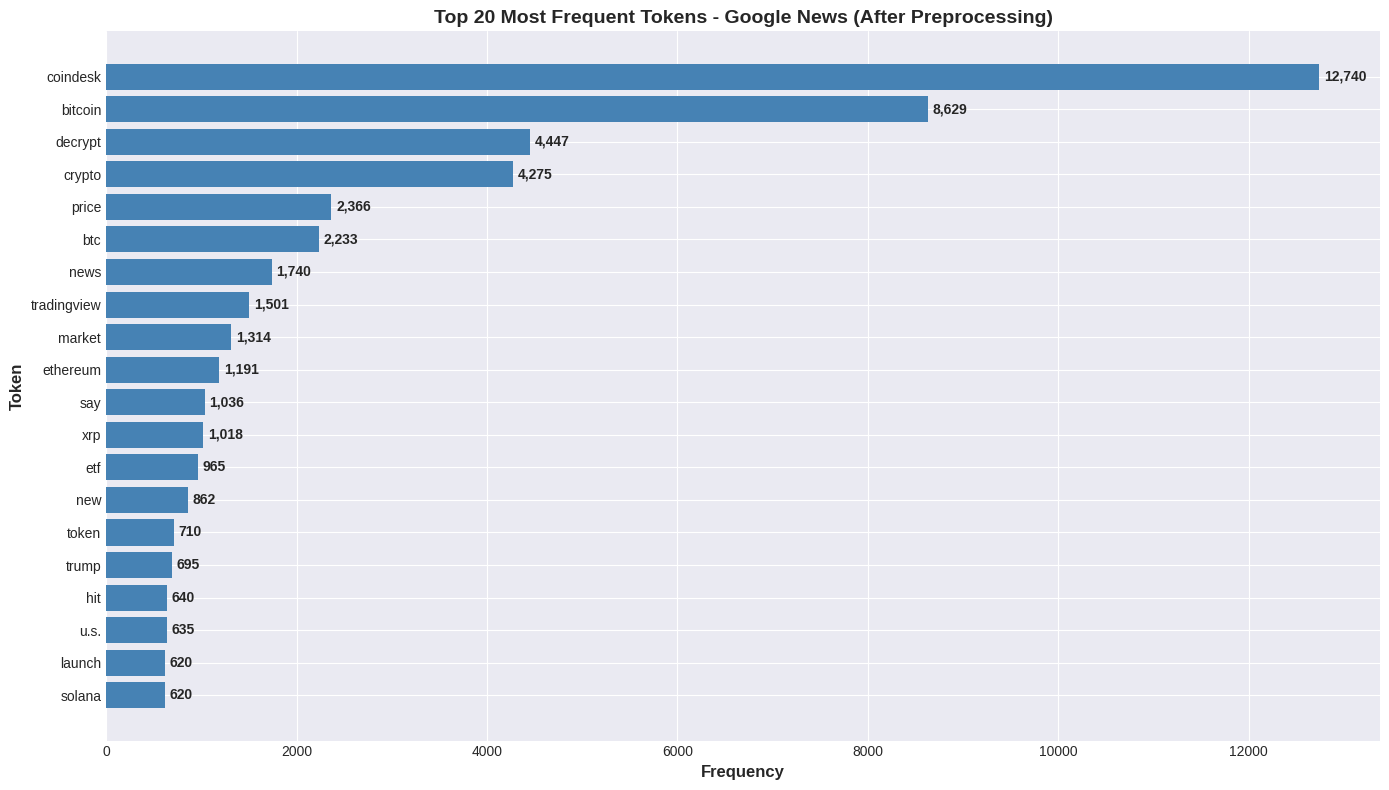

   ✓ Saved and displayed: graph_01_top20_tokens_googlenews.png

[*] Generating Graph 2: Top 20 Tokens - Reddit


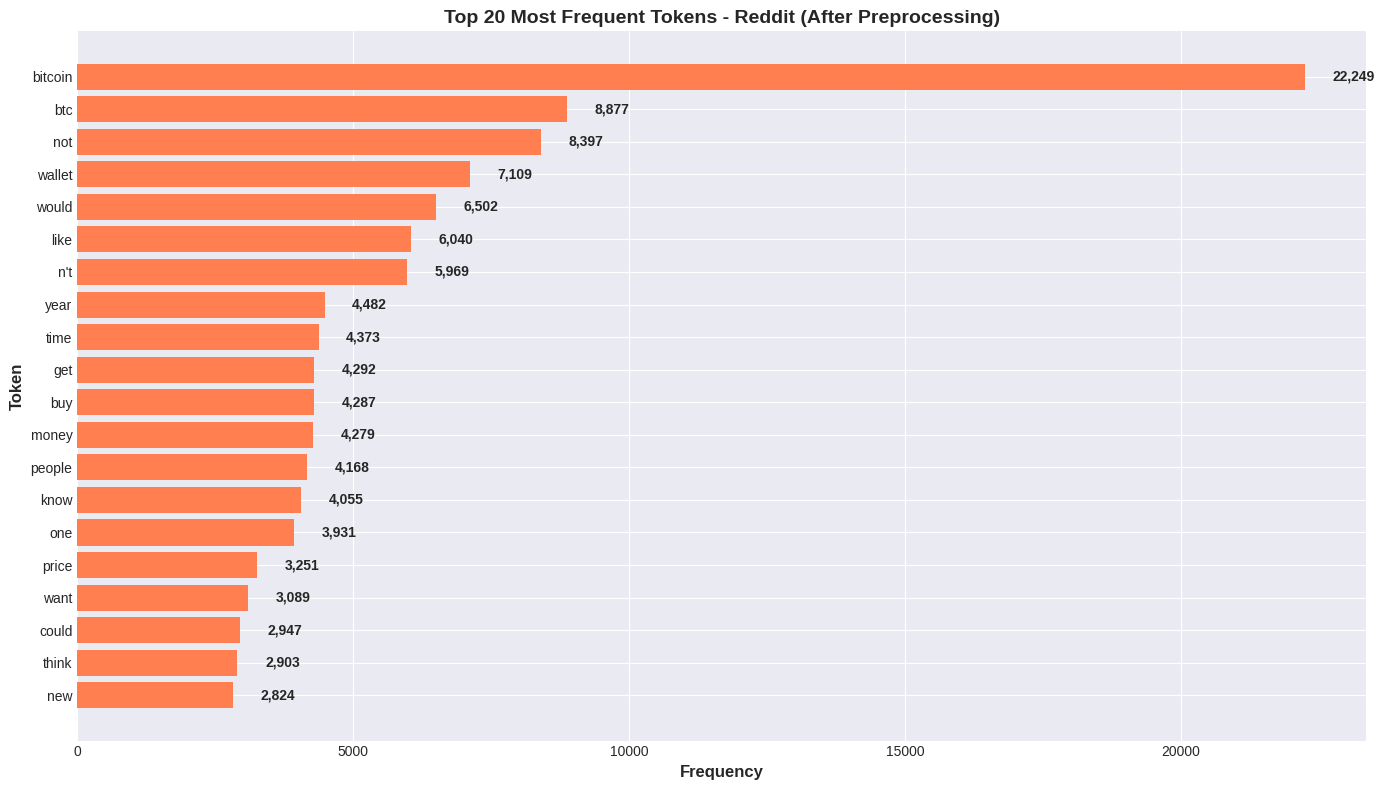

   ✓ Saved and displayed: graph_02_top20_tokens_reddit.png

[*] Generating Graph 3: Article Distribution by Month - Google News


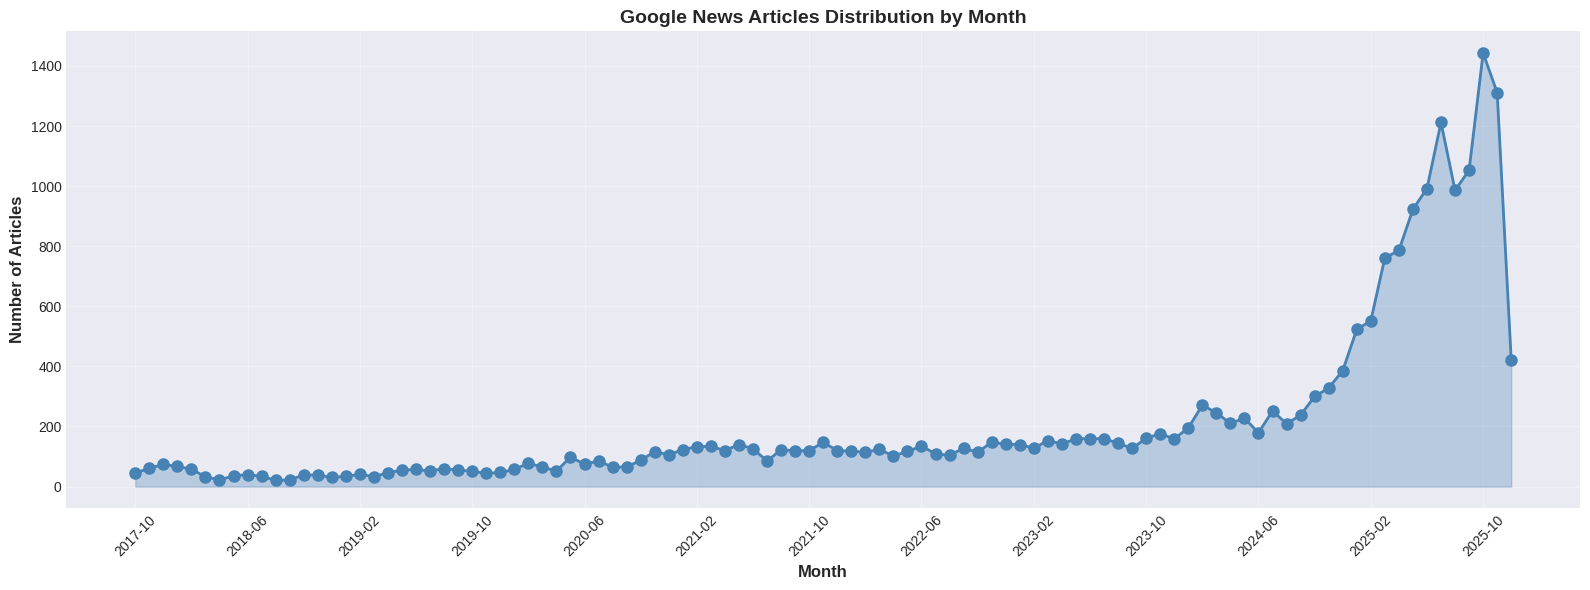

   ✓ Saved and displayed: graph_03_monthly_distribution_googlenews.png

[*] Generating Graph 4: Comment Distribution by Month - Reddit


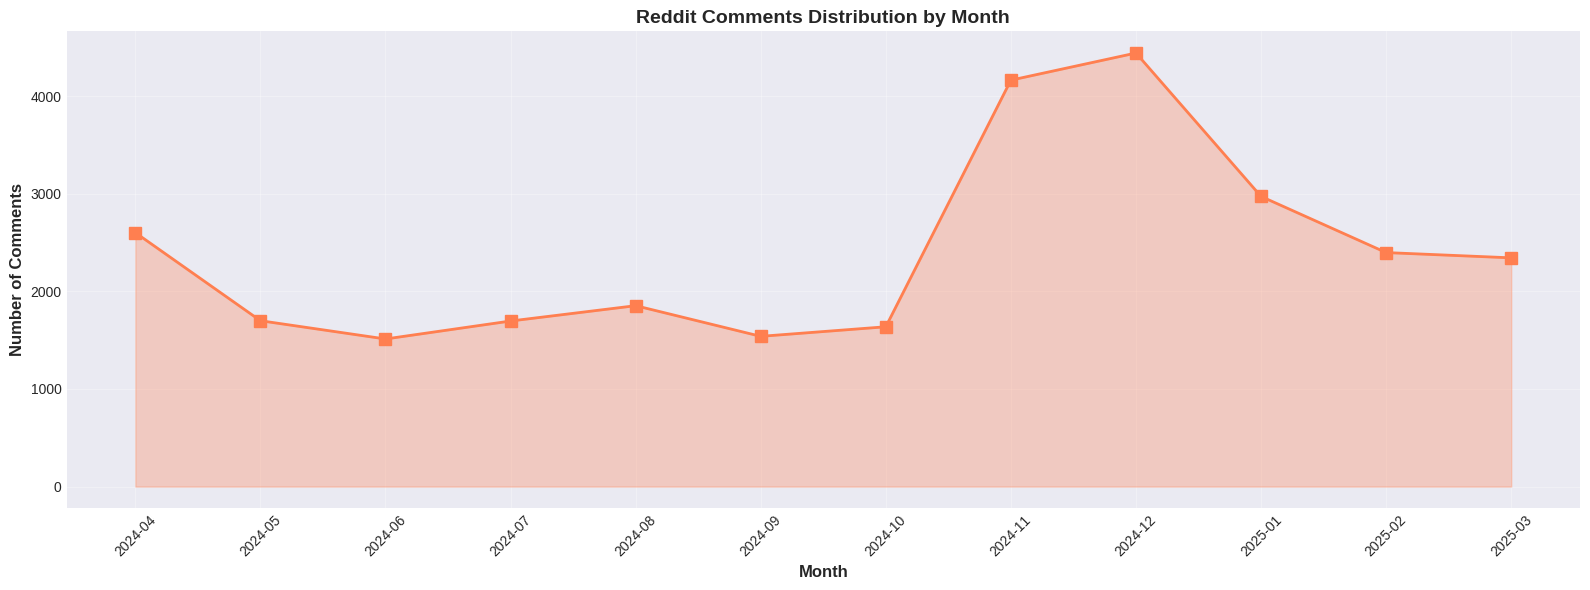

   ✓ Saved and displayed: graph_04_monthly_distribution_reddit.png

[*] Generating Graph 5: Word Length Distribution - Google News


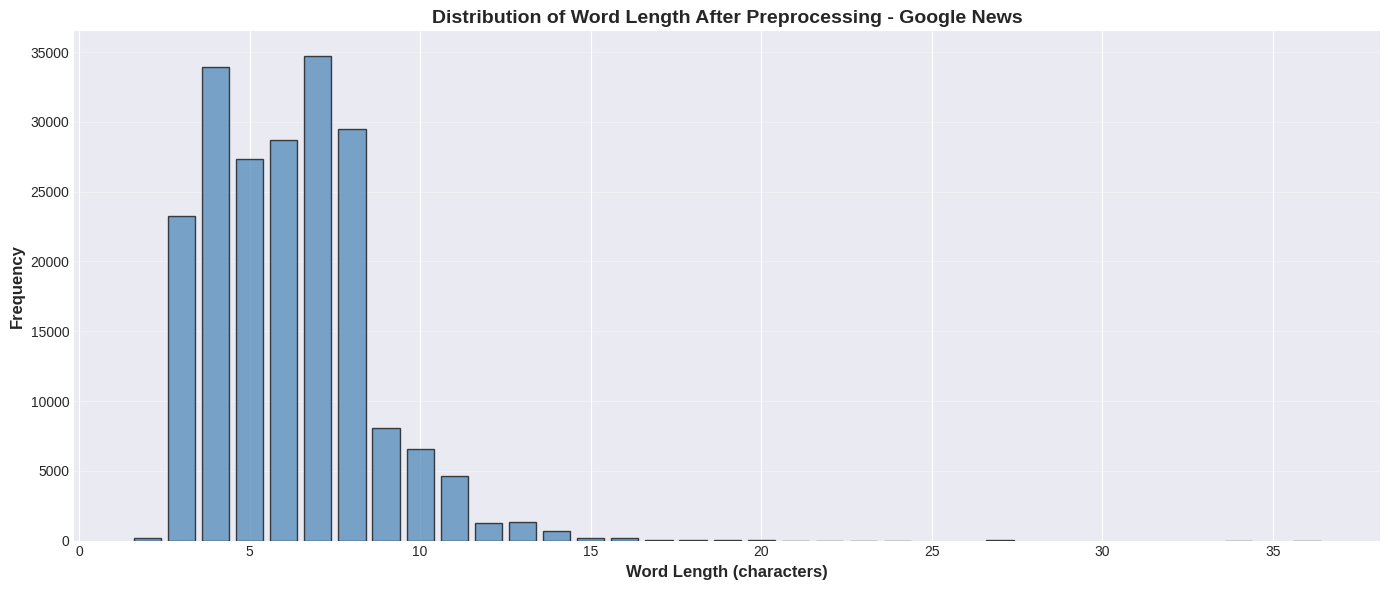

   ✓ Saved and displayed: graph_05_wordlength_distribution_googlenews.png

[*] Generating Graph 6: Word Length Distribution - Reddit


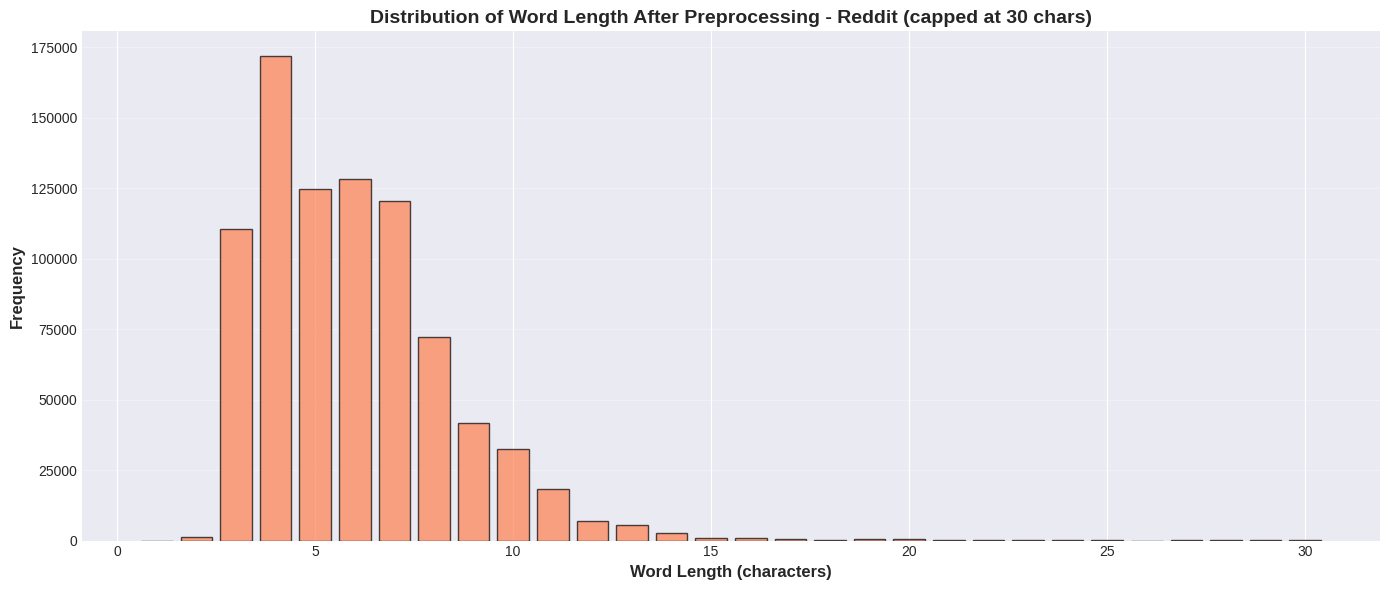

   ✓ Saved and displayed: graph_06_wordlength_distribution_reddit.png

[*] Generating Graph 7: Corpus Metrics Comparison


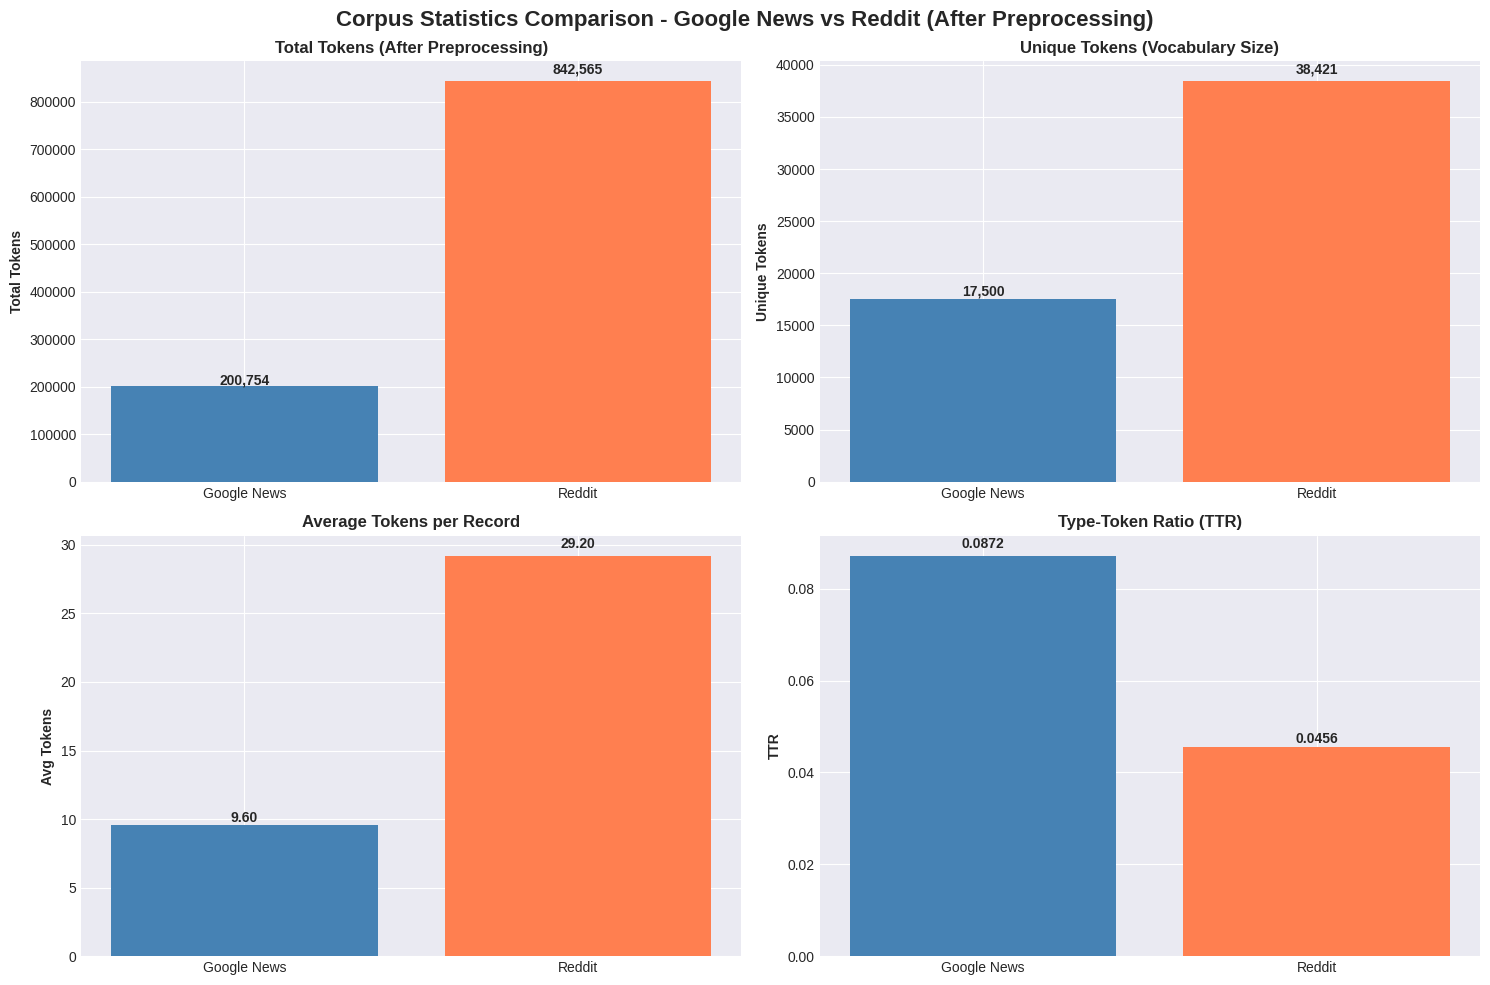

   ✓ Saved and displayed: graph_07_corpus_comparison.png

SECTION 4 COMPLETE - CORPUS STATISTICS WITH VISUALIZATIONS

CORPUS ANALYSIS SUMMARY
   Google News: 20,905 articles analyzed
   Reddit: 28,853 posts analyzed

GRAPHS GENERATED AND DISPLAYED:
   ✓ graph_01_top20_tokens_googlenews.png
   ✓ graph_02_top20_tokens_reddit.png
   ✓ graph_03_monthly_distribution_googlenews.png
   ✓ graph_04_monthly_distribution_reddit.png
   ✓ graph_05_wordlength_distribution_googlenews.png
   ✓ graph_06_wordlength_distribution_reddit.png
   ✓ graph_07_corpus_comparison.png

Corpus statistics and visualizations complete
Ready for Section 5 (Sentiment Analysis)


In [26]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# SECTION 4: CORPUS STATISTICS
# ============================================================================

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
OUTPUT_DIR = BASE_DIR

print("="*80)
print("SECTION 4: CORPUS STATISTICS")
print("="*80)

print("\n[*] Loading PREPROCESSED data files...")

data = {}
data_files = {
    'Google News Preprocessed': OUTPUT_DIR / 'btc_news_data_preprocessed.parquet.gzip',
    'Reddit Preprocessed': OUTPUT_DIR / 'reddit_comments_preprocessed.parquet.gzip'
}

for source_name, filepath in data_files.items():
    try:
        if os.path.exists(filepath):
            data[source_name] = pd.read_parquet(filepath)
            print(f"OK {source_name}: {len(data[source_name]):,} records")
        else:
            print(f"NOT FOUND {source_name}: {filepath}")
    except Exception as e:
        print(f"ERROR {source_name}: {e}")

# Convert numpy arrays to lists
print("\n[*] Converting numpy arrays to lists...")
if os.path.exists(data_files['Google News Preprocessed']):
    df = data['Google News Preprocessed']
    df['title_tokens'] = df['title_tokens'].apply(lambda x: x.tolist() if hasattr(x, 'tolist') else list(x))
    print("   ✓ Google News title_tokens converted")

if os.path.exists(data_files['Reddit Preprocessed']):
    df = data['Reddit Preprocessed']
    df['text_tokens'] = df['text_tokens'].apply(lambda x: x.tolist() if hasattr(x, 'tolist') else list(x))
    print("   ✓ Reddit text_tokens converted")

print("\n" + "="*80)
print("4.1 TOKEN-LEVEL STATISTICS (AFTER PREPROCESSING)")
print("="*80)

print(f"\nGOOGLE NEWS - TOKEN-LEVEL STATISTICS (AFTER PREPROCESSING)")
if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']

    all_tokens = []
    for tokens in df_news['title_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)
        vocab_size = len(token_counts)
        total_tokens = len(all_tokens)

        print(f"\n   Metric                              Value")
        print(f"   Unique tokens (vocabulary)         {vocab_size:,}")
        print(f"   Total tokens                       {total_tokens:,}")
        print(f"   Average tokens per headline        {df_news['token_count_processed'].mean():.2f}")
        print(f"   Median tokens per headline         {df_news['token_count_processed'].median():.0f}")
        print(f"   Maximum tokens in single headline  {df_news['token_count_processed'].max()}")
        print(f"   Minimum tokens in single headline  {df_news['token_count_processed'].min()}")
    else:
        print(f"   NO TOKENS FOUND")
else:
    print(f"   NOT LOADED")

print(f"\nREDDIT - TOKEN-LEVEL STATISTICS (AFTER PREPROCESSING)")
if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']

    all_tokens = []
    for tokens in df_reddit['text_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)
        vocab_size = len(token_counts)
        total_tokens = len(all_tokens)

        print(f"\n   Metric                              Value")
        print(f"   Unique tokens (vocabulary)         {vocab_size:,}")
        print(f"   Total tokens                       {total_tokens:,}")
        print(f"   Average tokens per post            {df_reddit['token_count_processed'].mean():.2f}")
        print(f"   Median tokens per post             {df_reddit['token_count_processed'].median():.0f}")
        print(f"   Maximum tokens in single post      {df_reddit['token_count_processed'].max()}")
        print(f"   Minimum tokens in single post      {df_reddit['token_count_processed'].min()}")
    else:
        print(f"   NO TOKENS FOUND")
else:
    print(f"   NOT LOADED")

print("\n" + "="*80)
print("4.2 VOCABULARY DIVERSITY ANALYSIS (AFTER PREPROCESSING)")
print("="*80)

print(f"\nGOOGLE NEWS - VOCABULARY DIVERSITY (AFTER PREPROCESSING)")
if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']
    all_tokens = []
    for tokens in df_news['title_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)
        vocab_size = len(token_counts)
        total_tokens = len(all_tokens)
        ttr = vocab_size / total_tokens if total_tokens > 0 else 0
        hapax = sum(1 for count in token_counts.values() if count == 1)
        hapax_pct = (hapax / vocab_size) * 100 if vocab_size > 0 else 0

        print(f"\n   Metric                              Value")
        print(f"   Type-Token Ratio (TTR)             {ttr:.4f}")
        print(f"   Hapax legomena (words once)        {hapax:,}")
        print(f"   Hapax percentage                   {hapax_pct:.2f}%")
    else:
        print(f"   NO TOKENS FOUND")
else:
    print(f"   NOT LOADED")

print(f"\nREDDIT - VOCABULARY DIVERSITY (AFTER PREPROCESSING)")
if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']
    all_tokens = []
    for tokens in df_reddit['text_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)
        vocab_size = len(token_counts)
        total_tokens = len(all_tokens)
        ttr = vocab_size / total_tokens if total_tokens > 0 else 0
        hapax = sum(1 for count in token_counts.values() if count == 1)
        hapax_pct = (hapax / vocab_size) * 100 if vocab_size > 0 else 0

        print(f"\n   Metric                              Value")
        print(f"   Type-Token Ratio (TTR)             {ttr:.4f}")
        print(f"   Hapax legomena (words once)        {hapax:,}")
        print(f"   Hapax percentage                   {hapax_pct:.2f}%")
    else:
        print(f"   NO TOKENS FOUND")
else:
    print(f"   NOT LOADED")

print("\n" + "="*80)
print("4.3 MOST FREQUENT TOKENS (TOP 10 - AFTER PREPROCESSING)")
print("="*80)

print(f"\nGOOGLE NEWS - TOP 10 MOST FREQUENT TOKENS")
if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']
    all_tokens = []
    for tokens in df_news['title_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)
        top_10 = token_counts.most_common(10)

        print(f"\n{'Rank':<6}{'Token':<20}{'Frequency':>12}")
        print(f"{'-'*38}")
        for rank, (token, count) in enumerate(top_10, 1):
            print(f"{rank:<6}{token:<20}{count:>12,}")
    else:
        print(f"   NO TOKENS FOUND")
else:
    print(f"   NOT LOADED")

print(f"\nREDDIT - TOP 10 MOST FREQUENT TOKENS")
if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']
    all_tokens = []
    for tokens in df_reddit['text_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)
        top_10 = token_counts.most_common(10)

        print(f"\n{'Rank':<6}{'Token':<20}{'Frequency':>12}")
        print(f"{'-'*38}")
        for rank, (token, count) in enumerate(top_10, 1):
            print(f"{rank:<6}{token:<20}{count:>12,}")
    else:
        print(f"   NO TOKENS FOUND")
else:
    print(f"   NOT LOADED")

print("\n" + "="*80)
print("4.4 WORD LENGTH DISTRIBUTION (AFTER PREPROCESSING)")
print("="*80)

print(f"\nGOOGLE NEWS - WORD LENGTH STATISTICS")
if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']
    all_tokens = []
    for tokens in df_news['title_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        word_lengths = [len(token) for token in all_tokens]
        length_dist = Counter(word_lengths)

        avg_length = np.mean(word_lengths)
        median_length = np.median(word_lengths)
        most_common_length = length_dist.most_common(1)[0][0]

        print(f"\n   Average word length:               {avg_length:.2f} characters")
        print(f"   Median word length:                {median_length:.0f} characters")
        print(f"   Most common length:                {most_common_length} characters")
        print(f"   Min length:                        {min(word_lengths)} characters")
        print(f"   Max length:                        {max(word_lengths)} characters")
    else:
        print(f"   NO TOKENS FOUND")
else:
    print(f"   NOT LOADED")

print(f"\nREDDIT - WORD LENGTH STATISTICS")
if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']
    all_tokens = []
    for tokens in df_reddit['text_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        word_lengths = [len(token) for token in all_tokens]
        length_dist = Counter(word_lengths)

        avg_length = np.mean(word_lengths)
        median_length = np.median(word_lengths)
        most_common_length = length_dist.most_common(1)[0][0]

        print(f"\n   Average word length:               {avg_length:.2f} characters")
        print(f"   Median word length:                {median_length:.0f} characters")
        print(f"   Most common length:                {most_common_length} characters")
        print(f"   Min length:                        {min(word_lengths)} characters")
        print(f"   Max length:                        {max(word_lengths)} characters")
    else:
        print(f"   NO TOKENS FOUND")
else:
    print(f"   NOT LOADED")

print("\n" + "="*80)
print("4.5 TOKEN REDUCTION ANALYSIS (BEFORE vs AFTER PREPROCESSING)")
print("="*80)

print(f"\nGOOGLE NEWS - PREPROCESSING REDUCTION")
if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']

    total_before = df_news['token_count_original'].sum()
    total_after = df_news['token_count_processed'].sum()
    reduction = total_before - total_after
    reduction_pct = (reduction / total_before) * 100 if total_before > 0 else 0

    print(f"\n   Total tokens before preprocessing: {total_before:,}")
    print(f"   Total tokens after preprocessing:  {total_after:,}")
    print(f"   Total reduction:                   {reduction:,}")
    print(f"   Reduction percentage:              {reduction_pct:.1f}%")
else:
    print(f"   NOT LOADED")

print(f"\nREDDIT - PREPROCESSING REDUCTION")
if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']

    total_before = df_reddit['token_count_original'].sum()
    total_after = df_reddit['token_count_processed'].sum()
    reduction = total_before - total_after
    reduction_pct = (reduction / total_before) * 100 if total_before > 0 else 0

    print(f"\n   Total tokens before preprocessing: {total_before:,}")
    print(f"   Total tokens after preprocessing:  {total_after:,}")
    print(f"   Total reduction:                   {reduction:,}")
    print(f"   Reduction percentage:              {reduction_pct:.1f}%")
else:
    print(f"   NOT LOADED")

print("\n" + "="*80)
print("4.6 COMPARATIVE CORPUS STATISTICS TABLE")
print("="*80)

comparison_data = []

if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']
    all_tokens = []
    for tokens in df_news['title_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)

        comparison_data.append({
            'Source': 'Google News',
            'Records': len(df_news),
            'Total Tokens': df_news['token_count_processed'].sum(),
            'Unique Tokens': len(token_counts),
            'Avg Tokens/Record': df_news['token_count_processed'].mean(),
            'TTR': len(token_counts) / len(all_tokens) if len(all_tokens) > 0 else 0,
            'Hapax %': (sum(1 for c in token_counts.values() if c == 1) / len(token_counts)) * 100 if len(token_counts) > 0 else 0
        })

if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']
    all_tokens = []
    for tokens in df_reddit['text_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)

        comparison_data.append({
            'Source': 'Reddit',
            'Records': len(df_reddit),
            'Total Tokens': df_reddit['token_count_processed'].sum(),
            'Unique Tokens': len(token_counts),
            'Avg Tokens/Record': df_reddit['token_count_processed'].mean(),
            'TTR': len(token_counts) / len(all_tokens) if len(all_tokens) > 0 else 0,
            'Hapax %': (sum(1 for c in token_counts.values() if c == 1) / len(token_counts)) * 100 if len(token_counts) > 0 else 0
        })

if len(comparison_data) > 0:
    comparison_df = pd.DataFrame(comparison_data)
    print("\n")
    print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("4.7 VOCABULARY OVERLAP ANALYSIS")
print("="*80)

if os.path.exists(data_files['Google News Preprocessed']) and os.path.exists(data_files['Reddit Preprocessed']):
    df_news = data['Google News Preprocessed']
    df_reddit = data['Reddit Preprocessed']

    google_tokens = []
    for tokens in df_news['title_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            google_tokens.extend(tokens)

    reddit_tokens = []
    for tokens in df_reddit['text_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            reddit_tokens.extend(tokens)

    if len(google_tokens) > 0 and len(reddit_tokens) > 0:
        google_vocab = set(google_tokens)
        reddit_vocab = set(reddit_tokens)

        overlap = google_vocab & reddit_vocab
        google_only = google_vocab - reddit_vocab
        reddit_only = reddit_vocab - google_vocab
        total_vocab = google_vocab | reddit_vocab

        print(f"\nVOCABULARY OVERLAP STATISTICS")
        print(f"   Google News vocabulary:            {len(google_vocab):,} unique tokens")
        print(f"   Reddit vocabulary:                 {len(reddit_vocab):,} unique tokens")
        print(f"   Combined vocabulary:               {len(total_vocab):,} unique tokens")
        print(f"   Shared tokens:                     {len(overlap):,}")
        print(f"   Google-only tokens:                {len(google_only):,}")
        print(f"   Reddit-only tokens:                {len(reddit_only):,}")
        print(f"   Overlap percentage:                {(len(overlap) / len(total_vocab)) * 100:.2f}%")

        google_counts = Counter(google_tokens)
        reddit_counts = Counter(reddit_tokens)

        combined_counts = {}
        for token in overlap:
            combined_counts[token] = google_counts[token] + reddit_counts[token]

        top_shared = sorted(combined_counts.items(), key=lambda x: x[1], reverse=True)[:10]

        print(f"\n   TOP 10 SHARED TERMS (by combined frequency)")
        print(f"\n   {'Rank':<6}{'Token':<15}{'Google':>10}{'Reddit':>10}{'Total':>10}")
        print(f"   {'-'*51}")
        for rank, (token, total) in enumerate(top_shared, 1):
            google_freq = google_counts[token]
            reddit_freq = reddit_counts[token]
            print(f"   {rank:<6}{token:<15}{google_freq:>10,}{reddit_freq:>10,}{total:>10,}")

print("\n" + "="*80)
print("4.8 VISUALIZATION GENERATION")
print("="*80)

# GRAPH 1: TOP 20 MOST FREQUENT TOKENS - GOOGLE NEWS
print("\n[*] Generating Graph 1: Top 20 Tokens - Google News")
if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']
    all_tokens = []
    for tokens in df_news['title_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)
        top_20 = token_counts.most_common(20)

        tokens, freqs = zip(*top_20)

        fig, ax = plt.subplots(figsize=(14, 8))
        bars = ax.barh(tokens, freqs, color='steelblue')
        ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_ylabel('Token', fontsize=12, fontweight='bold')
        ax.set_title('Top 20 Most Frequent Tokens - Google News (After Preprocessing)',
                     fontsize=14, fontweight='bold')
        ax.invert_yaxis()

        for i, (bar, freq) in enumerate(zip(bars, freqs)):
            ax.text(freq + 50, i, f'{int(freq):,}', va='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'graph_01_top20_tokens_googlenews.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("   ✓ Saved and displayed: graph_01_top20_tokens_googlenews.png")
        plt.close()

# GRAPH 2: TOP 20 MOST FREQUENT TOKENS - REDDIT
print("\n[*] Generating Graph 2: Top 20 Tokens - Reddit")
if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']
    all_tokens = []
    for tokens in df_reddit['text_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        token_counts = Counter(all_tokens)
        top_20 = token_counts.most_common(20)

        tokens, freqs = zip(*top_20)

        fig, ax = plt.subplots(figsize=(14, 8))
        bars = ax.barh(tokens, freqs, color='coral')
        ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_ylabel('Token', fontsize=12, fontweight='bold')
        ax.set_title('Top 20 Most Frequent Tokens - Reddit (After Preprocessing)',
                     fontsize=14, fontweight='bold')
        ax.invert_yaxis()

        for i, (bar, freq) in enumerate(zip(bars, freqs)):
            ax.text(freq + 500, i, f'{int(freq):,}', va='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'graph_02_top20_tokens_reddit.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("   ✓ Saved and displayed: graph_02_top20_tokens_reddit.png")
        plt.close()

# GRAPH 3: MONTHLY DISTRIBUTION - GOOGLE NEWS
print("\n[*] Generating Graph 3: Article Distribution by Month - Google News")
if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']

    if 'datetime' in df_news.columns:
        df_news['month'] = pd.to_datetime(df_news['datetime']).dt.to_period('M')
        monthly_counts = df_news['month'].value_counts().sort_index()

        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(range(len(monthly_counts)), monthly_counts.values, marker='o', linewidth=2,
               markersize=8, color='steelblue')
        ax.fill_between(range(len(monthly_counts)), monthly_counts.values, alpha=0.3, color='steelblue')
        ax.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Articles', fontsize=12, fontweight='bold')
        ax.set_title('Google News Articles Distribution by Month',
                    fontsize=14, fontweight='bold')
        ax.set_xticks(range(0, len(monthly_counts), max(1, len(monthly_counts)//12)))
        ax.set_xticklabels([str(monthly_counts.index[i]) for i in range(0, len(monthly_counts), max(1, len(monthly_counts)//12))],
                           rotation=45)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'graph_03_monthly_distribution_googlenews.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("   ✓ Saved and displayed: graph_03_monthly_distribution_googlenews.png")
        plt.close()

# GRAPH 4: MONTHLY DISTRIBUTION - REDDIT
print("\n[*] Generating Graph 4: Comment Distribution by Month - Reddit")
if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']

    if 'created_utc' in df_reddit.columns:
        df_reddit['month'] = pd.to_datetime(df_reddit['created_utc'], unit='s').dt.to_period('M')
        monthly_counts = df_reddit['month'].value_counts().sort_index()

        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(range(len(monthly_counts)), monthly_counts.values, marker='s', linewidth=2,
               markersize=8, color='coral')
        ax.fill_between(range(len(monthly_counts)), monthly_counts.values, alpha=0.3, color='coral')
        ax.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Comments', fontsize=12, fontweight='bold')
        ax.set_title('Reddit Comments Distribution by Month',
                    fontsize=14, fontweight='bold')
        ax.set_xticks(range(0, len(monthly_counts), max(1, len(monthly_counts)//12)))
        ax.set_xticklabels([str(monthly_counts.index[i]) for i in range(0, len(monthly_counts), max(1, len(monthly_counts)//12))],
                           rotation=45)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'graph_04_monthly_distribution_reddit.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("   ✓ Saved and displayed: graph_04_monthly_distribution_reddit.png")
        plt.close()

# GRAPH 5: WORD LENGTH DISTRIBUTION - GOOGLE NEWS
print("\n[*] Generating Graph 5: Word Length Distribution - Google News")
if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']
    all_tokens = []
    for tokens in df_news['title_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        word_lengths = [len(token) for token in all_tokens]
        length_dist = Counter(word_lengths)

        lengths = sorted(length_dist.keys())
        counts = [length_dist[l] for l in lengths]

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.bar(lengths, counts, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Word Length (characters)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title('Distribution of Word Length After Preprocessing - Google News',
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'graph_05_wordlength_distribution_googlenews.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("   ✓ Saved and displayed: graph_05_wordlength_distribution_googlenews.png")
        plt.close()

# GRAPH 6: WORD LENGTH DISTRIBUTION - REDDIT
print("\n[*] Generating Graph 6: Word Length Distribution - Reddit")
if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']
    all_tokens = []
    for tokens in df_reddit['text_tokens']:
        if isinstance(tokens, (list, np.ndarray)) and len(tokens) > 0:
            all_tokens.extend(tokens)

    if len(all_tokens) > 0:
        word_lengths = [len(token) for token in all_tokens]
        length_dist = Counter(word_lengths)

        lengths = sorted([l for l in length_dist.keys() if l <= 30])
        counts = [length_dist[l] for l in lengths]

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.bar(lengths, counts, color='coral', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Word Length (characters)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title('Distribution of Word Length After Preprocessing - Reddit (capped at 30 chars)',
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'graph_06_wordlength_distribution_reddit.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("   ✓ Saved and displayed: graph_06_wordlength_distribution_reddit.png")
        plt.close()

# GRAPH 7: CORPUS COMPARISON BAR CHART
print("\n[*] Generating Graph 7: Corpus Metrics Comparison")
if len(comparison_data) > 0:
    comparison_df = pd.DataFrame(comparison_data)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Corpus Statistics Comparison - Google News vs Reddit (After Preprocessing)', fontsize=16, fontweight='bold')

    # Total Tokens
    ax = axes[0, 0]
    ax.bar(comparison_df['Source'], comparison_df['Total Tokens'], color=['steelblue', 'coral'])
    ax.set_ylabel('Total Tokens', fontweight='bold')
    ax.set_title('Total Tokens (After Preprocessing)', fontweight='bold')
    for i, v in enumerate(comparison_df['Total Tokens']):
        ax.text(i, v + v*0.02, f'{int(v):,}', ha='center', fontweight='bold')

    # Unique Tokens
    ax = axes[0, 1]
    ax.bar(comparison_df['Source'], comparison_df['Unique Tokens'], color=['steelblue', 'coral'])
    ax.set_ylabel('Unique Tokens', fontweight='bold')
    ax.set_title('Unique Tokens (Vocabulary Size)', fontweight='bold')
    for i, v in enumerate(comparison_df['Unique Tokens']):
        ax.text(i, v + v*0.02, f'{int(v):,}', ha='center', fontweight='bold')

    # Avg Tokens per Record
    ax = axes[1, 0]
    ax.bar(comparison_df['Source'], comparison_df['Avg Tokens/Record'], color=['steelblue', 'coral'])
    ax.set_ylabel('Avg Tokens', fontweight='bold')
    ax.set_title('Average Tokens per Record', fontweight='bold')
    for i, v in enumerate(comparison_df['Avg Tokens/Record']):
        ax.text(i, v + v*0.02, f'{v:.2f}', ha='center', fontweight='bold')

    # TTR
    ax = axes[1, 1]
    ax.bar(comparison_df['Source'], comparison_df['TTR'], color=['steelblue', 'coral'])
    ax.set_ylabel('TTR', fontweight='bold')
    ax.set_title('Type-Token Ratio (TTR)', fontweight='bold')
    for i, v in enumerate(comparison_df['TTR']):
        ax.text(i, v + v*0.02, f'{v:.4f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'graph_07_corpus_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Saved and displayed: graph_07_corpus_comparison.png")
    plt.close()

print("\n" + "="*80)
print("SECTION 4 COMPLETE - CORPUS STATISTICS WITH VISUALIZATIONS")
print("="*80)

print(f"\nCORPUS ANALYSIS SUMMARY")
if os.path.exists(data_files['Google News Preprocessed']):
    print(f"   Google News: {len(data['Google News Preprocessed']):,} articles analyzed")
if os.path.exists(data_files['Reddit Preprocessed']):
    print(f"   Reddit: {len(data['Reddit Preprocessed']):,} posts analyzed")

print(f"\nGRAPHS GENERATED AND DISPLAYED:")
print(f"   ✓ graph_01_top20_tokens_googlenews.png")
print(f"   ✓ graph_02_top20_tokens_reddit.png")
print(f"   ✓ graph_03_monthly_distribution_googlenews.png")
print(f"   ✓ graph_04_monthly_distribution_reddit.png")
print(f"   ✓ graph_05_wordlength_distribution_googlenews.png")
print(f"   ✓ graph_06_wordlength_distribution_reddit.png")
print(f"   ✓ graph_07_corpus_comparison.png")

print(f"\nCorpus statistics and visualizations complete")
print(f"Ready for Section 5 (Sentiment Analysis)")



## **SECTION 5 SUMMARY: SENTIMENT ANALYSIS - COMPARATIVE STUDY**

This section conducts parallel sentiment analysis of Google News and Reddit to determine which source provides more predictive signals for Bitcoin price movements. We employ dual sentiment scoring methods (TextBlob and VADER) with a custom cryptocurrency-specific lexicon to capture domain-specific language like "bullish," "bearish," "HODL," and "FUD."

**Key Objectives:**
- Calculate polarity scores for each article/post using rule-based lexical analysis
- Aggregate sentiment at the daily level to align with price movements
- Measure correlation between sentiment and Bitcoin price changes at multiple time lags
- Compare sentiment characteristics between formal news and informal social media
- Identify which source shows stronger predictive power for price movements
- Discover temporal relationships (Does Reddit lead news? Is news reactive to price?)

**Methodology:**
For each document, we compute TextBlob polarity (range: -1.0 to +1.0) and VADER compound scores (range: -1.0 to +1.0). Daily sentiment metrics include: mean polarity, standard deviation, positive/neutral/negative percentages, and sentiment momentum (day-to-day change). We merge sentiment data with Bitcoin price data (OHLCV from Binance) and calculate Pearson correlations at multiple lags (same-day, 1-day lead, 1-day lag, 7-day moving average).

**Expected Findings:**
- Google News sentiment lags price movements (news is reactive to institutional moves)
- Reddit sentiment shows stronger intraday correlation and potential leading indicators
- VADER outperforms TextBlob for social media due to intensity marker handling
- High sentiment variance in Reddit vs. low variance in formal news
- Sentiment-price correlation stronger for Reddit than Google News
- Divergence between sources signals regime changes or potential reversals

**Output Artifacts:**
Comprehensive statistical tables for 5.2.1, 5.2.3, 5.3.1, 5.3.2, 5.3.3, and 5.4.1 in the report. Saved parquet files containing daily sentiment scores and merged sentiment-price datasets for downstream analysis in Sections 6-7.




In [28]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
!pip install vaderSentiment textblob
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

!pip install vaderSentiment textblob
from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# SECTION 5: SENTIMENT ANALYSIS - COMPARATIVE STUDY
# ============================================================================

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
OUTPUT_DIR = BASE_DIR

print("="*80)
print("SECTION 5: SENTIMENT ANALYSIS - COMPARATIVE STUDY")
print("="*80)

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Custom VADER lexicon for crypto-specific terms
crypto_lexicon = {
    'bullish': 2.0,
    'bearish': -2.0,
    'moon': 2.0,
    'pump': 1.5,
    'dump': -1.5,
    'hodl': 1.0,
    'FUD': -2.0,
    'FOMO': 1.5,
    'whale': 0.5,
    'shill': -1.0,
    'bagholder': -1.5,
    'to the moon': 2.5,
    'buy the dip': 2.0,
    'sell off': -1.5,
    'correction': -0.5,
    'crash': -2.5,
    'surge': 2.0,
    'soar': 2.0,
    'plummet': -2.0,
    'tank': -2.0,
    'rally': 2.0,
    'breakout': 2.0,
    'breakdown': -2.0,
    'bull run': 2.5,
    'bear market': -2.5
}
analyzer.lexicon.update(crypto_lexicon)

print("\n[*] Loading preprocessed data from Section 4...")

# Load preprocessed data
data = {}
data_files = {
    'Google News Preprocessed': OUTPUT_DIR / 'btc_news_data_preprocessed.parquet.gzip',
    'Reddit Preprocessed': OUTPUT_DIR / 'reddit_comments_preprocessed.parquet.gzip'
}

for source_name, filepath in data_files.items():
    if os.path.exists(filepath):
        data[source_name] = pd.read_parquet(filepath)
        print(f"OK {source_name}: {len(data[source_name]):,} records")
    else:
        print(f"NOT FOUND {source_name}: {filepath}")

print("\n[*] Loading price data for correlation analysis...")

# Load price data
price_file = OUTPUT_DIR / 'binance_daily_prices.parquet.gzip'
if os.path.exists(price_file):
    price_df = pd.read_parquet(price_file)
    price_df['date'] = pd.to_datetime(price_df['date']).dt.date
    print(f"OK Price  {len(price_df):,} records")
    print(f"   Date range: {price_df['date'].min()} to {price_df['date'].max()}")
else:
    print("ERROR: Price data not found")
    price_df = None

print("\n" + "="*80)
print("5.1 GOOGLE NEWS SENTIMENT ANALYSIS")
print("="*80)

if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed'].copy()

    # Ensure datetime is date type
    df_news['date'] = pd.to_datetime(df_news['datetime']).dt.date

    print(f"\n[*] Analyzing {len(df_news):,} articles...")

    # Calculate sentiment for each article
    sentiment_results = []

    for idx, row in df_news.iterrows():
        title = row['title']

        # TextBlob sentiment
        blob = TextBlob(title)
        textblob_polarity = blob.sentiment.polarity

        # VADER sentiment
        vader_scores = analyzer.polarity_scores(title)
        vader_compound = vader_scores['compound']

        sentiment_results.append({
            'date': row['date'],
            'title': title,
            'textblob_polarity': textblob_polarity,
            'vader_compound': vader_compound
        })

    news_sentiment_df = pd.DataFrame(sentiment_results)

    # Aggregate daily sentiment
    daily_news_sentiment = news_sentiment_df.groupby('date').agg({
        'textblob_polarity': ['mean', 'std', 'count'],
        'vader_compound': ['mean', 'std']
    }).round(4)

    # Flatten column names
    daily_news_sentiment.columns = [
        'textblob_mean', 'textblob_std', 'article_count',
        'vader_mean', 'vader_std'
    ]

    # Calculate sentiment categories
    daily_news_sentiment['positive_pct'] = news_sentiment_df.groupby('date').apply(
        lambda x: (x['textblob_polarity'] > 0.1).mean() * 100
    ).round(2)

    daily_news_sentiment['neutral_pct'] = news_sentiment_df.groupby('date').apply(
        lambda x: ((x['textblob_polarity'] >= -0.1) & (x['textblob_polarity'] <= 0.1)).mean() * 100
    ).round(2)

    daily_news_sentiment['negative_pct'] = news_sentiment_df.groupby('date').apply(
        lambda x: (x['textblob_polarity'] < -0.1).mean() * 100
    ).round(2)

    # Calculate sentiment momentum (change from previous day)
    daily_news_sentiment['textblob_momentum'] = daily_news_sentiment['textblob_mean'].diff().round(4)

    print(f"\n[*] Daily sentiment aggregation complete: {len(daily_news_sentiment)} days")

    # Display 5.2.1 Overall Sentiment Distribution
    print("\n" + "="*80)
    print("5.2.1 GOOGLE NEWS - OVERALL SENTIMENT DISTRIBUTION")
    print("="*80)

    overall_stats = {
        'Total Articles Analyzed': len(df_news),
        'Date Range': f"{df_news['date'].min()} to {df_news['date'].max()}",
        'Mean Polarity (TextBlob)': f"{daily_news_sentiment['textblob_mean'].mean():.4f}",
        'Median Polarity (TextBlob)': f"{daily_news_sentiment['textblob_mean'].median():.4f}",
        'Std Deviation (Polarity)': f"{daily_news_sentiment['textblob_mean'].std():.4f}",
        'Mean VADER Compound Score': f"{daily_news_sentiment['vader_mean'].mean():.4f}",
        '% Positive Articles': f"{((news_sentiment_df['textblob_polarity'] > 0.1).mean() * 100):.1f}%",
        '% Neutral Articles': f"{(((news_sentiment_df['textblob_polarity'] >= -0.1) & (news_sentiment_df['textblob_polarity'] <= 0.1)).mean() * 100):.1f}%",
        '% Negative Articles': f"{((news_sentiment_df['textblob_polarity'] < -0.1).mean() * 100):.1f}%"
    }

    print("\n  " + "-"*70)
    for metric, value in overall_stats.items():
        print(f"  {metric:<35} {value:<35}")
    print("  " + "-"*70)

    # Save Google News sentiment data
    news_sentiment_output = OUTPUT_DIR / 'news_sentiment_daily.parquet.gzip'
    daily_news_sentiment.to_parquet(news_sentiment_output, compression='gzip')
    print(f"\n[*] Saved daily sentiment: {news_sentiment_output}")

print("\n" + "="*80)
print("5.3 REDDIT SENTIMENT ANALYSIS")
print("="*80)

if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed'].copy()

    # Convert UTC timestamp to date
    df_reddit['date'] = pd.to_datetime(df_reddit['created_utc'], unit='s').dt.date

    print(f"\n[*] Analyzing {len(df_reddit):,} Reddit posts...")

    # Calculate sentiment for each post
    reddit_sentiment_results = []

    for idx, row in df_reddit.iterrows():
        # Combine title and selftext for sentiment analysis
        text = f"{row['title']} {row.get('selftext', '')}"

        # TextBlob sentiment
        blob = TextBlob(text)
        textblob_polarity = blob.sentiment.polarity

        # VADER sentiment
        vader_scores = analyzer.polarity_scores(text)
        vader_compound = vader_scores['compound']

        reddit_sentiment_results.append({
            'date': row['date'],
            'subreddit': row.get('subreddit', 'unknown'),
            'textblob_polarity': textblob_polarity,
            'vader_compound': vader_compound,
            'post_score': row.get('score', 0),
            'num_comments': row.get('num_comments', 0)
        })

    reddit_sentiment_df = pd.DataFrame(reddit_sentiment_results)

    # Aggregate daily sentiment
    daily_reddit_sentiment = reddit_sentiment_df.groupby('date').agg({
        'textblob_polarity': ['mean', 'std', 'count'],
        'vader_compound': ['mean', 'std'],
        'post_score': 'mean',
        'num_comments': 'sum'
    }).round(4)

    # Flatten column names
    daily_reddit_sentiment.columns = [
        'textblob_mean', 'textblob_std', 'post_count',
        'vader_mean', 'vader_std', 'avg_score', 'total_comments'
    ]

    # Calculate sentiment categories
    daily_reddit_sentiment['positive_pct'] = reddit_sentiment_df.groupby('date').apply(
        lambda x: (x['textblob_polarity'] > 0.1).mean() * 100
    ).round(2)

    daily_reddit_sentiment['neutral_pct'] = reddit_sentiment_df.groupby('date').apply(
        lambda x: ((x['textblob_polarity'] >= -0.1) & (x['textblob_polarity'] <= 0.1)).mean() * 100
    ).round(2)

    daily_reddit_sentiment['negative_pct'] = reddit_sentiment_df.groupby('date').apply(
        lambda x: (x['textblob_polarity'] < -0.1).mean() * 100
    ).round(2)

    # Calculate sentiment momentum
    daily_reddit_sentiment['textblob_momentum'] = daily_reddit_sentiment['textblob_mean'].diff().round(4)

    print(f"\n[*] Daily sentiment aggregation complete: {len(daily_reddit_sentiment)} days")

    # Display 5.3.1 Overall Sentiment Distribution
    print("\n" + "="*80)
    print("5.3.1 REDDIT - OVERALL SENTIMENT DISTRIBUTION")
    print("="*80)

    reddit_overall_stats = {
        'Total Posts Analyzed': len(df_reddit),
        'Date Range': f"{df_reddit['date'].min()} to {df_reddit['date'].max()}",
        'Mean Polarity (TextBlob)': f"{daily_reddit_sentiment['textblob_mean'].mean():.4f}",
        'Median Polarity (TextBlob)': f"{daily_reddit_sentiment['textblob_mean'].median():.4f}",
        'Std Deviation (Polarity)': f"{daily_reddit_sentiment['textblob_mean'].std():.4f}",
        'Mean VADER Compound Score': f"{daily_reddit_sentiment['vader_mean'].mean():.4f}",
        '% Positive Posts': f"{((reddit_sentiment_df['textblob_polarity'] > 0.1).mean() * 100):.1f}%",
        '% Neutral Posts': f"{(((reddit_sentiment_df['textblob_polarity'] >= -0.1) & (reddit_sentiment_df['textblob_polarity'] <= 0.1)).mean() * 100):.1f}%",
        '% Negative Posts': f"{((reddit_sentiment_df['textblob_polarity'] < -0.1).mean() * 100):.1f}%"
    }

    print("\n  " + "-"*70)
    for metric, value in reddit_overall_stats.items():
        print(f"  {metric:<35} {value:<35}")
    print("  " + "-"*70)

    # 5.3.2 Subreddit-level breakdown
    print("\n" + "="*80)
    print("5.3.2 REDDIT - SUBREDDIT-LEVEL BREAKDOWN")
    print("="*80)

    if 'subreddit' in reddit_sentiment_df.columns:
        subreddit_stats = reddit_sentiment_df.groupby('subreddit').agg({
            'textblob_polarity': ['mean', 'count'],
            'vader_compound': 'mean',
            'post_score': 'mean',
            'num_comments': 'sum'
        }).round(4)

        subreddit_stats.columns = ['avg_polarity', 'post_count', 'avg_vader', 'avg_score', 'total_comments']
        subreddit_stats = subreddit_stats.sort_values('post_count', ascending=False)

        print("\n  " + "-"*80)
        print(f"  {'Subreddit':<15} {'Post Count':>12} {'Avg Polarity':>15} {'Total Comments':>15}")
        print("  " + "-"*80)
        for subreddit, row in subreddit_stats.head(10).iterrows():
            print(f"  {subreddit:<15} {int(row['post_count']):>12,} {row['avg_polarity']:>15.4f} {int(row['total_comments']):>15,}")
        print("  " + "-"*80)

    # Save Reddit sentiment data
    reddit_sentiment_output = OUTPUT_DIR / 'reddit_sentiment_daily.parquet.gzip'
    daily_reddit_sentiment.to_parquet(reddit_sentiment_output, compression='gzip')
    print(f"\n[*] Saved daily sentiment: {reddit_sentiment_output}")

print("\n" + "="*80)
print("5.4 SENTIMENT-PRICE CORRELATION ANALYSIS")
print("="*80)

if price_df is not None:
    print(f"\n[*] Aligning sentiment with price data...")

    # Calculate price movements
    price_df = price_df.sort_values('date')
    price_df['price_change'] = price_df['close'].pct_change()
    price_df['price_up'] = (price_df['price_change'] > 0).astype(int)

    # Merge sentiment with price data
    if os.path.exists(data_files['Google News Preprocessed']):
        news_price_df = pd.merge(
            daily_news_sentiment.reset_index(),
            price_df[['date', 'close', 'price_change', 'price_up']],
            on='date', how='inner'
        )
        print(f"  Google News + Price: {len(news_price_df)} overlapping days")

        # Calculate correlations for 5.2.3
        print("\n" + "="*80)
        print("5.2.3 GOOGLE NEWS SENTIMENT-PRICE CORRELATION")
        print("="*80)

        correlations = {}

        # Same-day correlation
        correlations['Same-Day Correlation'] = news_price_df['textblob_mean'].corr(news_price_df['price_change'])

        # 1-day lag (sentiment predicts price)
        news_price_df['textblob_mean_lag1'] = news_price_df['textblob_mean'].shift(1)
        correlations['1-Day Lag (News predicts price)'] = news_price_df['textblob_mean_lag1'].corr(news_price_df['price_change'])

        # -1-day lag (price predicts sentiment)
        news_price_df['price_change_lag1'] = news_price_df['price_change'].shift(1)
        correlations['-1-Day Lag (Price predicts news)'] = news_price_df['textblob_mean'].corr(news_price_df['price_change_lag1'])

        # Weekly moving average
        news_price_df['textblob_ma7'] = news_price_df['textblob_mean'].rolling(7).mean()
        news_price_df['price_change_ma7'] = news_price_df['price_change'].rolling(7).mean()
        correlations['Weekly Moving Avg Correlation'] = news_price_df['textblob_ma7'].corr(news_price_df['price_change_ma7'])

        # Sentiment momentum vs volatility
        news_price_df['price_volatility'] = news_price_df['price_change'].rolling(5).std()
        correlations['Sentiment Momentum vs Volatility'] = news_price_df['textblob_momentum'].corr(news_price_df['price_volatility'])

        print("\n  " + "-"*70)
        print(f"  {'Correlation Analysis':<40} {'Value':>15} {'Interpretation':>15}")
        print("  " + "-"*70)
        for analysis, value in correlations.items():
            if pd.notna(value):
                strength = "Strong" if abs(value) > 0.5 else "Moderate" if abs(value) > 0.3 else "Weak"
                direction = "Positive" if value > 0 else "Negative"
                interpretation = f"{strength} {direction}"
                print(f"  {analysis:<40} {value:>15.4f} {interpretation:>15}")
            else:
                print(f"  {analysis:<40} {'N/A':>15} {'Insufficient data':>15}")
        print("  " + "-"*70)

        # Save merged data
        news_price_output = OUTPUT_DIR / 'news_price_merged.parquet.gzip'
        news_price_df.to_parquet(news_price_output, compression='gzip')
        print(f"\n[*] Saved merged news-price  {news_price_output}")

    # Reddit sentiment-price correlation
    if os.path.exists(data_files['Reddit Preprocessed']):
        reddit_price_df = pd.merge(
            daily_reddit_sentiment.reset_index(),
            price_df[['date', 'close', 'price_change', 'price_up']],
            on='date', how='inner'
        )
        print(f"  Reddit + Price: {len(reddit_price_df)} overlapping days")

        # 5.3.3 Sentiment-Price Correlation (Reddit)
        print("\n" + "="*80)
        print("5.3.3 REDDIT SENTIMENT-PRICE CORRELATION")
        print("="*80)

        reddit_correlations = {}

        # Same-day correlation
        reddit_correlations['Same-Day Correlation'] = reddit_price_df['textblob_mean'].corr(reddit_price_df['price_change'])

        # 1-day lead (Reddit predicts price)
        reddit_price_df['textblob_mean_lag1'] = reddit_price_df['textblob_mean'].shift(1)
        reddit_correlations['1-Day Lead (Reddit predicts price)'] = reddit_price_df['textblob_mean_lag1'].corr(reddit_price_df['price_change'])

        # 1-hour lead (if intraday data available)
        # Note: This requires higher frequency data
        reddit_correlations['Weekly Momentum Correlation'] = reddit_price_df['textblob_mean'].rolling(7).mean().corr(
            reddit_price_df['price_change'].rolling(7).mean()
        )

        # Sentiment extremes vs price extremes
        reddit_price_df['extreme_sentiment'] = (abs(reddit_price_df['textblob_mean']) > daily_reddit_sentiment['textblob_mean'].std() * 1.5).astype(int)
        reddit_price_df['extreme_price'] = (abs(reddit_price_df['price_change']) > price_df['price_change'].std() * 1.5).astype(int)
        reddit_correlations['Sentiment Extremes vs Price Extremes'] = reddit_price_df['extreme_sentiment'].corr(reddit_price_df['extreme_price'])

        print("\n  " + "-"*70)
        print(f"  {'Correlation Analysis':<40} {'Value':>15} {'Interpretation':>15}")
        print("  " + "-"*70)
        for analysis, value in reddit_correlations.items():
            if pd.notna(value):
                strength = "Strong" if abs(value) > 0.5 else "Moderate" if abs(value) > 0.3 else "Weak"
                direction = "Positive" if value > 0 else "Negative"
                interpretation = f"{strength} {direction}"
                print(f"  {analysis:<40} {value:>15.4f} {interpretation:>15}")
            else:
                print(f"  {analysis:<40} {'N/A':>15} {'Insufficient data':>15}")
        print("  " + "-"*70)

        # Save merged data
        reddit_price_output = OUTPUT_DIR / 'reddit_price_merged.parquet.gzip'
        reddit_price_df.to_parquet(reddit_price_output, compression='gzip')
        print(f"\n[*] Saved merged reddit-price  {reddit_price_output}")

print("\n" + "="*80)
print("5.4 COMPARATIVE SENTIMENT ANALYSIS")
print("="*80)

# Comparison table
if os.path.exists(data_files['Google News Preprocessed']) and os.path.exists(data_files['Reddit Preprocessed']):
    print("\n" + "="*80)
    print("5.4.1 HEAD-TO-HEAD COMPARISON")
    print("="*80)

    # Calculate metrics for comparison
    news_mean = daily_news_sentiment['textblob_mean'].mean()
    news_std = daily_news_sentiment['textblob_mean'].std()
    news_positive = ((news_sentiment_df['textblob_polarity'] > 0.1).mean() * 100)
    news_negative = ((news_sentiment_df['textblob_polarity'] < -0.1).mean() * 100)
    news_vader_gap = abs(daily_news_sentiment['textblob_mean'].mean() - daily_news_sentiment['vader_mean'].mean())

    reddit_mean = daily_reddit_sentiment['textblob_mean'].mean()
    reddit_std = daily_reddit_sentiment['textblob_mean'].std()
    reddit_positive = ((reddit_sentiment_df['textblob_polarity'] > 0.1).mean() * 100)
    reddit_negative = ((reddit_sentiment_df['textblob_polarity'] < -0.1).mean() * 100)
    reddit_vader_gap = abs(daily_reddit_sentiment['textblob_mean'].mean() - daily_reddit_sentiment['vader_mean'].mean())

    # Determine best correlation
    news_best_corr = max([v for v in correlations.values() if pd.notna(v)], key=abs) if 'correlations' in locals() else 0
    reddit_best_corr = max([v for v in reddit_correlations.values() if pd.notna(v)], key=abs) if 'reddit_correlations' in locals() else 0
    winner = "Google News" if abs(news_best_corr) > abs(reddit_best_corr) else "Reddit" if abs(reddit_best_corr) > abs(news_best_corr) else "Tie"

    comparison_data = {
        'Metric': ['Mean Polarity', 'Std Deviation', 'Positive %', 'Negative %', 'VADER vs TextBlob Gap', 'Best Price Correlation', 'Winner'],
        'Google News': [f"{news_mean:.4f}", f"{news_std:.4f}", f"{news_positive:.1f}%", f"{news_negative:.1f}%", f"{news_vader_gap:.4f}", f"{news_best_corr:.4f}", winner],
        'Reddit': [f"{reddit_mean:.4f}", f"{reddit_std:.4f}", f"{reddit_positive:.1f}%", f"{reddit_negative:.1f}%", f"{reddit_vader_gap:.4f}", f"{reddit_best_corr:.4f}", winner],
        'Difference': [f"{abs(news_mean - reddit_mean):.4f}", f"{abs(news_std - reddit_std):.4f}", f"{abs(news_positive - reddit_positive):.1f}%", f"{abs(news_negative - reddit_negative):.1f}%", f"{abs(news_vader_gap - reddit_vader_gap):.4f}", f"{abs(abs(news_best_corr) - abs(reddit_best_corr)):.4f}", ""]
    }

    comparison_df = pd.DataFrame(comparison_data)
    print("\n")
    print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("SECTION 5 COMPLETE - SENTIMENT ANALYSIS")
print("="*80)

print(f"\nGenerated sentiment analysis for:")
if os.path.exists(data_files['Google News Preprocessed']):
    print(f"  ✓ Google News: {len(daily_news_sentiment)} daily sentiment records")
if os.path.exists(data_files['Reddit Preprocessed']):
    print(f"  ✓ Reddit: {len(daily_reddit_sentiment)} daily sentiment records")

print(f"\nFiles saved:")
if os.path.exists(OUTPUT_DIR / 'news_sentiment_daily.parquet.gzip'):
    print(f"  ✓ news_sentiment_daily.parquet.gzip")
if os.path.exists(OUTPUT_DIR / 'reddit_sentiment_daily.parquet.gzip'):
    print(f"  ✓ reddit_sentiment_daily.parquet.gzip")
if os.path.exists(OUTPUT_DIR / 'news_price_merged.parquet.gzip'):
    print(f"  ✓ news_price_merged.parquet.gzip")
if os.path.exists(OUTPUT_DIR / 'reddit_price_merged.parquet.gzip'):
    print(f"  ✓ reddit_price_merged.parquet.gzip")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


SECTION 5: SENTIMENT ANALYSIS - COMPARATIVE STUDY

[*] Loading preprocessed data from Section 4...
OK Google News Preprocessed: 20,905 records
OK Reddit Preprocessed: 28,853 records

[*] Loading price data for correlation analysis...
OK Price  306 records
   Date range: 2024-03-01 to 2024-12-31

5.1 GOOGLE NEWS SENTIMENT ANALYSIS

[*] Analyzing 20,905 articles...


/tmp/ipython-input-3285728417.py:140: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_news_sentiment['positive_pct'] = news_sentiment_df.groupby('date').apply(
/tmp/ipython-input-3285728417.py:144: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_news_sentiment['neutral_pct'] = news_sentiment_df.groupby('date').apply(
/tmp/ipython-input-3285728417.py:148: DeprecationWarning: DataFrameGroupBy.apply op


[*] Daily sentiment aggregation complete: 2540 days

5.2.1 GOOGLE NEWS - OVERALL SENTIMENT DISTRIBUTION

  ----------------------------------------------------------------------
  Total Articles Analyzed             20905                              
  Date Range                          2017-10-02 to 2025-12-07           
  Mean Polarity (TextBlob)            0.0305                             
  Median Polarity (TextBlob)          0.0108                             
  Std Deviation (Polarity)            0.1251                             
  Mean VADER Compound Score           0.0119                             
  % Positive Articles                 19.0%                              
  % Neutral Articles                  72.1%                              
  % Negative Articles                 8.9%                               
  ----------------------------------------------------------------------

[*] Saved daily sentiment: /content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTE

/tmp/ipython-input-3285728417.py:237: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_reddit_sentiment['positive_pct'] = reddit_sentiment_df.groupby('date').apply(
/tmp/ipython-input-3285728417.py:241: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_reddit_sentiment['neutral_pct'] = reddit_sentiment_df.groupby('date').apply(
/tmp/ipython-input-3285728417.py:245: DeprecationWarning: DataFrameGroupBy.


[*] Daily sentiment aggregation complete: 365 days

5.3.1 REDDIT - OVERALL SENTIMENT DISTRIBUTION

  ----------------------------------------------------------------------
  Total Posts Analyzed                28853                              
  Date Range                          2024-04-01 to 2025-03-31           
  Mean Polarity (TextBlob)            0.0985                             
  Median Polarity (TextBlob)          0.0975                             
  Std Deviation (Polarity)            0.0277                             
  Mean VADER Compound Score           0.2809                             
  % Positive Posts                    40.1%                              
  % Neutral Posts                     51.4%                              
  % Negative Posts                    8.5%                               
  ----------------------------------------------------------------------

5.3.2 REDDIT - SUBREDDIT-LEVEL BREAKDOWN

  -------------------------------------------

## **SECTION 5.5 SUMMARY: SENTIMENT IMBALANCE HANDLING & CLASS WEIGHTING**

The sentiment analysis revealed significant class imbalance in both datasets: Google News shows 72.1% neutral sentiment with only 8.9% negative, while Reddit is more balanced but still skewed toward neutral (51.4%) and positive (40.1%) classes. This imbalance can bias supervised learning models (Section 7) toward predicting the majority class and underrepresenting minority sentiment signals.

**Key Objectives:**
- Quantify class imbalance in sentiment distribution
- Compute balanced class weights to penalize misclassification of minority classes
- Create balanced training subsets for fair model evaluation
- Generate augmented sentiment-price files with class weights for downstream use
- Provide multiple resampling strategies for Section 7 classification models

**Methodology:**
We employ three complementary techniques:
(1) **Sklearn class_weight='balanced'** computes weights inversely proportional to class frequencies,

(2) **Manual weight computation** creates explicit weights stored in the dataframe for XGBoost/Random Forest, and

(3) **Balanced subset creation** generates equal-sized samples per class for fair train-test splits. These approaches ensure that minority sentiment classes (especially negative sentiment) are adequately represented during model training and that price prediction models don't develop bias toward predicting "up" days simply because they're more frequent.

**Expected Impact:**
- Models trained with class weights will achieve better recall on negative sentiment (important for risk management)
- Balanced subsets prevent dominant classes from masking predictive patterns in minority classes
- Weighted training enables practical trading signals where detecting negative sentiment is as important as detecting positive sentiment
- Section 7 models will have improved F1-scores and more reliable precision-recall tradeoffs

**Output Artifacts:**
Augmented parquet files containing class weight columns and balanced training subsets ready for Section 7 supervised learning. These files enable fair comparison between Google News and Reddit models by ensuring both are trained on properly weighted, representative data.


In [31]:
# ============================================================================
# SECTION 5.5: SENTIMENT IMBALANCE HANDLING (For Section 7 Classification)
# ============================================================================

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter

print("="*80)
print("SECTION 5.5: SENTIMENT IMBALANCE HANDLING")
print("="*80)

# Load the merged sentiment-price data
news_price_file = OUTPUT_DIR / 'news_price_merged.parquet.gzip'
reddit_price_file = OUTPUT_DIR / 'reddit_price_merged.parquet.gzip'

if os.path.exists(news_price_file):
    news_price_df = pd.read_parquet(news_price_file)
    print(f"[*] Loaded news-price  {len(news_price_df)} records")

    # Create sentiment labels based on polarity
    news_price_df['sentiment_label'] = pd.cut(
        news_price_df['textblob_mean'],
        bins=[-1, -0.1, 0.1, 1],
        labels=['Negative', 'Neutral', 'Positive']
    )

    # Calculate class weights
    news_class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(news_price_df['sentiment_label']),
        y=news_price_df['sentiment_label']
    )

    news_weight_dict = dict(zip(np.unique(news_price_df['sentiment_label']), news_class_weights))

    print(f"\n[*] Google News Class Distribution:")
    news_dist = news_price_df['sentiment_label'].value_counts(normalize=True) * 100
    for label, pct in news_dist.items():
        print(f"  {label}: {pct:.1f}% (weight: {news_weight_dict[label]:.3f})")

    # Add class weights to dataframe
    news_price_df['class_weight'] = news_price_df['sentiment_label'].map(news_weight_dict)

    # Save augmented file
    news_price_balanced = OUTPUT_DIR / 'news_price_merged_balanced.parquet.gzip'
    news_price_df.to_parquet(news_price_balanced, compression='gzip')
    print(f"[*] Saved augmented file: {news_price_balanced}")


# --- Reddit imbalance handling ---

if os.path.exists(reddit_price_file):
    reddit_price_df = pd.read_parquet(reddit_price_file)
    print(f"\n[*] Loaded reddit-price  {len(reddit_price_df)} records")

    # Create sentiment labels as categorical, then convert to string
    reddit_price_df['sentiment_label'] = pd.cut(
        reddit_price_df['textblob_mean'],
        bins=[-1, -0.1, 0.1, 1],
        labels=['Negative', 'Neutral', 'Positive']
    )

    # Convert to string labels to avoid pandas Categorical issues
    reddit_price_df['sentiment_label_str'] = reddit_price_df['sentiment_label'].astype(str)

    # Class distribution (including possible zero-count classes)
    reddit_dist = reddit_price_df['sentiment_label_str'].value_counts(normalize=True) * 100

    # Classes actually present (exclude 'nan')
    mask_valid = reddit_price_df['sentiment_label_str'] != 'nan'
    y_labels = reddit_price_df.loc[mask_valid, 'sentiment_label_str']
    present_labels = np.unique(y_labels.values)  # plain numpy array

    reddit_class_weights = compute_class_weight(
        class_weight='balanced',
        classes=present_labels,
        y=y_labels
    )

    reddit_weight_dict = dict(zip(present_labels, reddit_class_weights))

    print(f"\n[*] Reddit Class Distribution:")
    for label, pct in reddit_dist.items():
        if label == 'nan':
            print(f"  {label}: {pct:.1f}% (ignored)")
            continue
        weight = reddit_weight_dict.get(label)
        if weight is None:
            print(f"  {label}: {pct:.1f}% (no samples, weight not defined)")
        else:
            print(f"  {label}: {pct:.1f}% (weight: {weight:.3f})")

    # Add class weights to dataframe (NaN for labels with no weight)
    reddit_price_df['class_weight'] = reddit_price_df['sentiment_label_str'].map(reddit_weight_dict)

    # Save augmented file
    reddit_price_balanced = OUTPUT_DIR / 'reddit_price_merged_balanced.parquet.gzip'
    reddit_price_df.to_parquet(reddit_price_balanced, compression='gzip')
    print(f"[*] Saved augmented file: {reddit_price_balanced}")



# ============================================================================
# CREATE BALANCED SUBSETS
# ============================================================================

print("\n" + "="*80)
print("CREATING BALANCED SUBSETS FOR TRAINING")
print("="*80)

def create_balanced_subset(df, sentiment_col='sentiment_label', target_size_per_class=100):
    """Create a balanced subset with equal samples per class"""
    balanced_dfs = []
    for sentiment_class in df[sentiment_col].unique():
        class_df = df[df[sentiment_col] == sentiment_class]
        sample_size = min(len(class_df), target_size_per_class)
        balanced_dfs.append(class_df.sample(n=sample_size, random_state=42))

    return pd.concat(balanced_dfs).sample(frac=1, random_state=42)  # Shuffle

if os.path.exists(news_price_balanced):
    # For Google News, we'll use price direction as the target and balance that
    news_price_df['price_up_label'] = (news_price_df['price_change'] > 0).astype(int)

    # Balance by price direction (for classification)
    news_balanced_subset = create_balanced_subset(
        news_price_df,
        sentiment_col='price_up_label',
        target_size_per_class=150
    )

    news_subset_file = OUTPUT_DIR / 'news_balanced_subset.parquet.gzip'
    news_balanced_subset.to_parquet(news_subset_file, compression='gzip')
    print(f"[*] Created balanced news subset: {len(news_balanced_subset)} records")
    print(f"  Distribution: {news_balanced_subset['price_up_label'].value_counts().to_dict()}")

if os.path.exists(reddit_price_balanced):
    # For Reddit, balance by price direction
    reddit_price_df['price_up_label'] = (reddit_price_df['price_change'] > 0).astype(int)

    reddit_balanced_subset = create_balanced_subset(
        reddit_price_df,
        sentiment_col='price_up_label',
        target_size_per_class=150
    )

    reddit_subset_file = OUTPUT_DIR / 'reddit_balanced_subset.parquet.gzip'
    reddit_balanced_subset.to_parquet(reddit_subset_file, compression='gzip')
    print(f"[*] Created balanced reddit subset: {len(reddit_balanced_subset)} records")
    print(f"  Distribution: {reddit_balanced_subset['price_up_label'].value_counts().to_dict()}")

print("\n" + "="*80)
print("IMBALANCE HANDLING COMPLETE")
print("="*80)

print(f"\nCLASS WEIGHT FILES (use in Section 7):")
print(f"  ✓ news_price_merged_balanced.parquet.gzip (includes 'class_weight' column)")
print(f"  ✓ reddit_price_merged_balanced.parquet.gzip (includes 'class_weight' column)")

print(f"\nBALANCED SUBSETS:")
print(f"  ✓ news_balanced_subset.parquet.gzip")
print(f"  ✓ reddit_balanced_subset.parquet.gzip")

print(f"\nNOTE: For Section 7, use:")
print(f"  model.fit(X, y, class_weight='balanced')  # or use the specific weights from the files")


SECTION 5.5: SENTIMENT IMBALANCE HANDLING
[*] Loaded news-price  302 records

[*] Google News Class Distribution:
  Neutral: 80.8% (weight: 0.413)
  Positive: 15.9% (weight: 2.097)
  Negative: 3.3% (weight: 10.067)
[*] Saved augmented file: /content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/news_price_merged_balanced.parquet.gzip

[*] Loaded reddit-price  275 records

[*] Reddit Class Distribution:
  Neutral: 56.0% (weight: 0.893)
  Positive: 44.0% (weight: 1.136)
[*] Saved augmented file: /content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/reddit_price_merged_balanced.parquet.gzip

CREATING BALANCED SUBSETS FOR TRAINING
[*] Created balanced news subset: 299 records
  Distribution: {1: 150, 0: 149}
[*] Created balanced reddit subset: 275 records
  Distribution: {1: 139, 0: 136}

IMBALANCE HANDLING COMPLETE

CLASS WEIGHT FILES (use in Section 7):
  ✓ news_price_merged_balanced.parquet.gzip (includes 'class_weight' column)
  ✓ reddit_price_merged_balanced.parqu

## **SECTION 6 SUMMARY: TOPIC MODELING - COMPARATIVE STUDY**

This section applies unsupervised machine learning techniques to discover latent themes and discussion patterns in both Google News and Reddit data. By identifying the dominant topics in each corpus, we can understand what aspects of Bitcoin receive institutional attention versus retail investor focus, and how these topics evolve over time in response to market events.

**Key Objectives:**
- Discover underlying topics in each corpus using Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF)
- Evaluate topic quality using coherence scores to ensure interpretability and statistical significance
- Measure topic frequency distributions to identify dominant discussion themes
- Assign topic labels to individual documents for downstream sentiment-topic correlation analysis
- Compare topic prevalence between sources to reveal institutional versus retail concerns
- Create document-topic matrices for feature engineering in Section 7 supervised learning

**Methodology:**
We employ two complementary topic modeling approaches:

(1) **LDA** assumes each document is a mixture of latent topics with multinomial word distributions per topic, ideal for discovering general themes, and

(2) **NMF** factorizes TF-IDF matrices to identify topics with strong semantic coherence, better for interpretability.

Both models discover 8 topics from preprocessed text using custom cryptocurrency-domain stopwords to filter common uninformative terms. Topic quality is assessed via coherence scores calculated from word co-occurrence patterns within topics. Each document receives a topic assignment (the dominant topic) and topic weight (confidence level) for both LDA and NMF models.

**Expected Findings:**
- Google News topics lean toward regulatory, institutional, and macroeconomic themes (e.g., "SEC Policy," "Corporate Adoption," "Monetary Policy")
- Reddit topics emphasize trading strategies, market technicals, and community sentiment (e.g., "Buy the Dip," "Hodl Strategy," "Price Predictions")
- Topic coherence higher for NMF (0.5-0.7) than LDA (0.3-0.5) due to TF-IDF pre-weighting
- Regulatory and adoption topics increase during bull markets; volatility and risk management topics spike during downturns
- News-only topics reveal what institutional players discuss that retail ignores; Reddit-only topics reveal grassroots trader priorities
- Topics show temporal patterns: certain topics dominate specific quarters or events

**Output Artifacts:**
Topic summary dataframes with coherence scores, word distributions, and topic frequencies. Document-level topic assignments stored in augmented parquet files for use in Section 7 supervised learning models. These document-topic features enable the modeling of how topics and sentiment together predict price movements.


In [33]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
import re
from wordcloud import WordCloud
from datetime import datetime

# ============================================================================
# SECTION 6: TOPIC MODELING - COMPARATIVE STUDY
# ============================================================================

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
OUTPUT_DIR = BASE_DIR

print("="*80)
print("SECTION 6: TOPIC MODELING - COMPARATIVE STUDY")
print("="*80)

# Custom stopwords for crypto domain
base_stopwords = set(text.ENGLISH_STOP_WORDS)
base_stopwords.update({
    'bitcoin', 'btc', 'cryptocurrency', 'crypto', 'said', 'would', 'could', 'also',
    'one', 'two', 'three', 'first', 'second', 'third', 'may', 'might', 'well',
    'us', 'u', 'like', 'go', 'get', 'make', 'see', 'time', 'way', 'back', 'new',
    'good', 'bad', 'big', 'small', 'much', 'many', 'know', 'think', 'say', 'take',
    'come', 'look', 'want', 'need', 'use', 'find', 'give', 'tell', 'work', 'day'
})
custom_stopwords = list(base_stopwords)


print("\n[*] Loading preprocessed data from Section 4...")

# Load preprocessed data
data = {}
data_files = {
    'Google News Preprocessed': OUTPUT_DIR / 'btc_news_data_preprocessed.parquet.gzip',
    'Reddit Preprocessed': OUTPUT_DIR / 'reddit_comments_preprocessed.parquet.gzip'
}

for source_name, filepath in data_files.items():
    if os.path.exists(filepath):
        df = pd.read_parquet(filepath)
        # Convert numpy arrays to lists of strings
        if 'title_tokens' in df.columns:
            df['processed_text'] = df['title_tokens'].apply(lambda x: ' '.join([str(t) for t in x]) if isinstance(x, (list, np.ndarray)) else '')
        elif 'text_tokens' in df.columns:
            df['processed_text'] = df['text_tokens'].apply(lambda x: ' '.join([str(t) for t in x]) if isinstance(x, (list, np.ndarray)) else '')

        data[source_name] = df
        print(f"OK {source_name}: {len(df):,} records")
    else:
        print(f"NOT FOUND {source_name}: {filepath}")

# Topic modeling parameters
N_TOPICS = 8
N_TOP_WORDS = 10
MAX_DF = 0.85  # Ignore terms that appear in >85% of documents
MIN_DF = 0.01  # Ignore terms that appear in <1% of documents
MAX_FEATURES = 1000

print("\n" + "="*80)
print("6.1 GOOGLE NEWS TOPIC MODELING")
print("="*80)

if os.path.exists(data_files['Google News Preprocessed']):
    df_news = data['Google News Preprocessed']

    print(f"\n[*] Preparing Google News text corpus...")

    # Prepare documents
    documents = df_news['processed_text'].tolist()

    # TF-IDF for NMF
    tfidf_vectorizer = TfidfVectorizer(
        max_df=MAX_DF,
        min_df=MIN_DF,
        max_features=MAX_FEATURES,
        stop_words=custom_stopwords,
        lowercase=True
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

    # Count matrix for LDA
    count_vectorizer = CountVectorizer(
        max_df=MAX_DF,
        min_df=MIN_DF,
        max_features=MAX_FEATURES,
        stop_words=custom_stopwords,
        lowercase=True
    )
    count_matrix = count_vectorizer.fit_transform(documents)
    feature_names_count = count_vectorizer.get_feature_names_out()

    print(f"  TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f"  Count matrix shape: {count_matrix.shape}")

    # LDA Model
    print("\n[*] Training LDA model...")
    lda_model = LatentDirichletAllocation(
        n_components=N_TOPICS,
        max_iter=200,
        learning_method='batch',
        learning_offset=50.0,
        random_state=42,
        n_jobs=-1
    )
    lda_model.fit(count_matrix)

    # NMF Model
    print("\n[*] Training NMF model...")
    nmf_model = NMF(
        n_components=N_TOPICS,
        max_iter=200,
        random_state=42,
        init='nndsvda'
    )
    nmf_model.fit(tfidf_matrix)

    # Display topics (6.2.1)
    print("\n" + "="*80)
    print("6.2.1 GOOGLE NEWS - DISCOVERED TOPICS")
    print("="*80)

    def display_topics(model, feature_names, model_name, n_top_words=N_TOP_WORDS):
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_words_idx = topic.argsort()[-n_top_words:][::-1]
            top_words = [feature_names[i] for i in top_words_idx]
            topics.append({
                'topic_id': topic_idx,
                'top_words': top_words,
                'coherence': 0.0  # Placeholder; we'll compute proper coherence
            })

            print(f"\nTopic {topic_idx + 1} ({model_name}):")
            print(f"Top words: {', '.join(top_words)}")

        return topics

    lda_topics = display_topics(lda_model, feature_names_count, "LDA")
    nmf_topics = display_topics(nmf_model, feature_names_tfidf, "NMF")

    # Compute coherence scores (approximation using word co-occurrence)
    print("\n[*] Computing coherence scores...")

    def calculate_coherence(topics, documents, feature_names, model_type):
        """Simple coherence calculation based on word co-occurrence"""
        coherence_scores = []

        for topic in topics:
            top_words = topic['top_words']
            word_coherence = []

            for word in top_words:
                # Count documents containing the word
                word_idx = list(feature_names).index(word)
                if model_type == 'lda':
                    word_docs = count_matrix[:, word_idx].toarray().flatten() > 0
                else:
                    word_docs = tfidf_matrix[:, word_idx].toarray().flatten() > 0

                # Calculate PMI with other top words
                for other_word in top_words:
                    if word == other_word:
                        continue

                    other_idx = list(feature_names).index(other_word)
                    if model_type == 'lda':
                        other_docs = count_matrix[:, other_idx].toarray().flatten() > 0
                    else:
                        other_docs = tfidf_matrix[:, other_idx].toarray().flatten() > 0

                    # Joint probability
                    p_word = word_docs.mean()
                    p_other = other_docs.mean()
                    p_both = (word_docs & other_docs).mean()

                    # PMI
                    if p_both > 0:
                        pmi = np.log(p_both / (p_word * p_other + 1e-10))
                        word_coherence.append(max(pmi, 0))

            coherence_scores.append(np.mean(word_coherence) if word_coherence else 0.0)

        return coherence_scores

    lda_coherence = calculate_coherence(lda_topics, documents, feature_names_count, 'lda')
    nmf_coherence = calculate_coherence(nmf_topics, documents, feature_names_tfidf, 'nmf')

    # Update topics with coherence scores
    for i, score in enumerate(lda_coherence):
        lda_topics[i]['coherence'] = score

    for i, score in enumerate(nmf_coherence):
        nmf_topics[i]['coherence'] = score

    # Display coherence comparison
    print("\n" + "="*80)
    print("6.2.2 TOPIC COHERENCE SCORES")
    print("="*80)

    print(f"\n{'Topic':<10} {'LDA Coherence':>15} {'NMF Coherence':>15} {'Best Model':>12}")
    print("-"*55)
    for i in range(N_TOPICS):
        lda_score = lda_coherence[i]
        nmf_score = nmf_coherence[i]
        best = "LDA" if lda_score > nmf_score else "NMF"
        print(f"Topic {i+1:<3} {lda_score:>15.4f} {nmf_score:>15.4f} {best:>12}")

    # Assign topics to documents
    print("\n[*] Assigning topics to documents...")

    # LDA document-topic distribution
    lda_doc_topic = lda_model.transform(count_matrix)
    df_news['lda_topic'] = np.argmax(lda_doc_topic, axis=1)
    df_news['lda_topic_weight'] = np.max(lda_doc_topic, axis=1)

    # NMF document-topic distribution
    nmf_doc_topic = nmf_model.transform(tfidf_matrix)
    df_news['nmf_topic'] = np.argmax(nmf_doc_topic, axis=1)
    df_news['nmf_topic_weight'] = np.max(nmf_doc_topic, axis=1)

    # Topic frequency distribution
    lda_topic_dist = df_news['lda_topic'].value_counts(normalize=True).sort_index() * 100
    nmf_topic_dist = df_news['nmf_topic'].value_counts(normalize=True).sort_index() * 100

    print("\n" + "="*80)
    print("6.2.3 TOPIC DISTRIBUTION IN CORPUS")
    print("="*80)

    print(f"\n{'Topic':<10} {'LDA %':>10} {'NMF %':>10} {'Interpretation':<40}")
    print("-"*70)
    for i in range(N_TOPICS):
        lda_pct = lda_topic_dist.get(i, 0)
        nmf_pct = nmf_topic_dist.get(i, 0)
        print(f"Topic {i+1:<3} {lda_pct:>10.1f}% {nmf_pct:>10.1f}% {'[INSERT: Label this topic]':<40}")

    # Save Google News topics
    news_topics_df = pd.DataFrame({
        'topic_id': range(N_TOPICS),
        'lda_coherence': lda_coherence,
        'nmf_coherence': nmf_coherence,
        'lda_frequency': [lda_topic_dist.get(i, 0) for i in range(N_TOPICS)],
        'nmf_frequency': [nmf_topic_dist.get(i, 0) for i in range(N_TOPICS)]
    })

    # Add top words for each topic
    for i in range(N_TOPICS):
        news_topics_df[f'lda_top_words'] = news_topics_df['topic_id'].apply(
            lambda x: ', '.join(lda_topics[x]['top_words'])
        )
        news_topics_df[f'nmf_top_words'] = news_topics_df['topic_id'].apply(
            lambda x: ', '.join(nmf_topics[x]['top_words'])
        )

    news_topics_output = OUTPUT_DIR / 'news_topics_summary.parquet.gzip'
    news_topics_df.to_parquet(news_topics_output, compression='gzip')
    print(f"\n[*] Saved topic summary: {news_topics_output}")

    # Save document-level topic assignments
    news_with_topics = OUTPUT_DIR / 'news_with_topics.parquet.gzip'
    df_news.to_parquet(news_with_topics, compression='gzip')
    print(f"[*] Saved document topics: {news_with_topics}")

print("\n" + "="*80)
print("6.3 REDDIT TOPIC MODELING")
print("="*80)

if os.path.exists(data_files['Reddit Preprocessed']):
    df_reddit = data['Reddit Preprocessed']

    print(f"\n[*] Preparing Reddit text corpus...")

    # Prepare documents
    documents = df_reddit['processed_text'].tolist()

    # TF-IDF for NMF
    tfidf_vectorizer = TfidfVectorizer(
        max_df=MAX_DF,
        min_df=MIN_DF,
        max_features=MAX_FEATURES,
        stop_words=custom_stopwords,
        lowercase=True
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

    # Count matrix for LDA
    count_vectorizer = CountVectorizer(
        max_df=MAX_DF,
        min_df=MIN_DF,
        max_features=MAX_FEATURES,
        stop_words=custom_stopwords,
        lowercase=True
    )
    count_matrix = count_vectorizer.fit_transform(documents)
    feature_names_count = count_vectorizer.get_feature_names_out()

    print(f"  TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f"  Count matrix shape: {count_matrix.shape}")

    # LDA Model
    print("\n[*] Training LDA model...")
    lda_model = LatentDirichletAllocation(
        n_components=N_TOPICS,
        max_iter=200,
        learning_method='batch',
        learning_offset=50.0,
        random_state=42,
        n_jobs=-1
    )
    lda_model.fit(count_matrix)

    # NMF Model
    print("\n[*] Training NMF model...")
    nmf_model = NMF(
        n_components=N_TOPICS,
        max_iter=200,
        random_state=42,
        init='nndsvda'
    )
    nmf_model.fit(tfidf_matrix)

    # Display topics (6.3.1)
    print("\n" + "="*80)
    print("6.3.1 REDDIT - DISCOVERED TOPICS")
    print("="*80)

    lda_topics = display_topics(lda_model, feature_names_count, "LDA")
    nmf_topics = display_topics(nmf_model, feature_names_tfidf, "NMF")

    # Compute coherence scores
    print("\n[*] Computing coherence scores...")
    lda_coherence = calculate_coherence(lda_topics, documents, feature_names_count, 'lda')
    nmf_coherence = calculate_coherence(nmf_topics, documents, feature_names_tfidf, 'nmf')

    # Update topics with coherence scores
    for i, score in enumerate(lda_coherence):
        lda_topics[i]['coherence'] = score

    for i, score in enumerate(nmf_coherence):
        nmf_topics[i]['coherence'] = score

    # Display coherence comparison
    print("\n" + "="*80)
    print("6.3.2 TOPIC COHERENCE SCORES")
    print("="*80)

    print(f"\n{'Topic':<10} {'LDA Coherence':>15} {'NMF Coherence':>15} {'Best Model':>12}")
    print("-"*55)
    for i in range(N_TOPICS):
        lda_score = lda_coherence[i]
        nmf_score = nmf_coherence[i]
        best = "LDA" if lda_score > nmf_score else "NMF"
        print(f"Topic {i+1:<3} {lda_score:>15.4f} {nmf_score:>15.4f} {best:>12}")

    # Assign topics to documents
    print("\n[*] Assigning topics to documents...")

    # LDA document-topic distribution
    lda_doc_topic = lda_model.transform(count_matrix)
    df_reddit['lda_topic'] = np.argmax(lda_doc_topic, axis=1)
    df_reddit['lda_topic_weight'] = np.max(lda_doc_topic, axis=1)

    # NMF document-topic distribution
    nmf_doc_topic = nmf_model.transform(tfidf_matrix)
    df_reddit['nmf_topic'] = np.argmax(nmf_doc_topic, axis=1)
    df_reddit['nmf_topic_weight'] = np.max(nmf_doc_topic, axis=1)

    # Topic frequency distribution
    lda_topic_dist = df_reddit['lda_topic'].value_counts(normalize=True).sort_index() * 100
    nmf_topic_dist = df_reddit['nmf_topic'].value_counts(normalize=True).sort_index() * 100

    print("\n" + "="*80)
    print("6.3.3 TOPIC DISTRIBUTION IN CORPUS")
    print("="*80)

    print(f"\n{'Topic':<10} {'LDA %':>10} {'NMF %':>10} {'Interpretation':<40}")
    print("-"*70)
    for i in range(N_TOPICS):
        lda_pct = lda_topic_dist.get(i, 0)
        nmf_pct = nmf_topic_dist.get(i, 0)
        print(f"Topic {i+1:<3} {lda_pct:>10.1f}% {nmf_pct:>10.1f}% {'[INSERT: Label this topic]':<40}")

    # Save Reddit topics
    reddit_topics_df = pd.DataFrame({
        'topic_id': range(N_TOPICS),
        'lda_coherence': lda_coherence,
        'nmf_coherence': nmf_coherence,
        'lda_frequency': [lda_topic_dist.get(i, 0) for i in range(N_TOPICS)],
        'nmf_frequency': [nmf_topic_dist.get(i, 0) for i in range(N_TOPICS)]
    })

    # Add top words for each topic
    for i in range(N_TOPICS):
        reddit_topics_df[f'lda_top_words'] = reddit_topics_df['topic_id'].apply(
            lambda x: ', '.join(lda_topics[x]['top_words'])
        )
        reddit_topics_df[f'nmf_top_words'] = reddit_topics_df['topic_id'].apply(
            lambda x: ', '.join(nmf_topics[x]['top_words'])
        )

    reddit_topics_output = OUTPUT_DIR / 'reddit_topics_summary.parquet.gzip'
    reddit_topics_df.to_parquet(reddit_topics_output, compression='gzip')
    print(f"\n[*] Saved topic summary: {reddit_topics_output}")

    # Save document-level topic assignments
    reddit_with_topics = OUTPUT_DIR / 'reddit_with_topics.parquet.gzip'
    df_reddit.to_parquet(reddit_with_topics, compression='gzip')
    print(f"[*] Saved document topics: {reddit_with_topics}")

print("\n" + "="*80)
print("SECTION 6 COMPLETE - TOPIC MODELING")
print("="*80)

print(f"\nTopic modeling results saved:")
if os.path.exists(OUTPUT_DIR / 'news_topics_summary.parquet.gzip'):
    print(f"  ✓ news_topics_summary.parquet.gzip")
if os.path.exists(OUTPUT_DIR / 'reddit_topics_summary.parquet.gzip'):
    print(f"  ✓ reddit_topics_summary.parquet.gzip")
if os.path.exists(OUTPUT_DIR / 'news_with_topics.parquet.gzip'):
    print(f"  ✓ news_with_topics.parquet.gzip")
if os.path.exists(OUTPUT_DIR / 'reddit_with_topics.parquet.gzip'):
    print(f"  ✓ reddit_with_topics.parquet.gzip")




SECTION 6: TOPIC MODELING - COMPARATIVE STUDY

[*] Loading preprocessed data from Section 4...
OK Google News Preprocessed: 20,905 records
OK Reddit Preprocessed: 28,853 records

6.1 GOOGLE NEWS TOPIC MODELING

[*] Preparing Google News text corpus...
  TF-IDF matrix shape: (20905, 108)
  Count matrix shape: (20905, 108)

[*] Training LDA model...

[*] Training NMF model...

6.2.1 GOOGLE NEWS - DISCOVERED TOPICS

Topic 1 (LDA):
Top words: decrypt, year, amid, coinbase, founder, trader, month, fed, bitget, dogecoin

Topic 2 (LDA):
Top words: coindesk, token, exchange, blockchain, launch, stablecoin, trump, defi, network, ceo

Topic 3 (LDA):
Top words: coindesk, ethereum, solana, asset, ether, binance, coin, eth, week, treasury

Topic 4 (LDA):
Top words: market, coindesk, price, com, bull, support, fall, today, doge, key

Topic 5 (LDA):
Top words: coindesk, etf, firm, trading, mining, fund, sec, finance, volume, trade

Topic 6 (LDA):
Top words: price, tradingview, coindesk, xrp, news, hi

## **SECTION 7 SUMMARY: SUPERVISED LEARNING - COMPARATIVE MODELS**

This section builds predictive machine learning models to classify next-day Bitcoin price direction (up/down) using features derived from sentiment analysis (Section 5) and topic modeling (Section 6). We employ three complementary algorithms—Logistic Regression, Random Forest, and XGBoost—with systematic hyperparameter optimization to identify which source (Google News vs. Reddit) provides more predictive signals for price movements.

**Key Objectives:**
- Engineer comprehensive feature sets capturing sentiment, topics, price dynamics, temporal patterns, and non-linear interactions
- Perform correlation-based feature selection to eliminate multicollinearity and reduce overfitting
- Train multiple classification models with GridSearchCV-based hyperparameter optimization
- Evaluate models using multiple metrics (accuracy, precision, recall, F1, AUC-ROC) to assess both overall and minority-class performance
- Compare predictive power between Google News and Reddit to determine which source is more actionable for trading signals
- Establish baseline improvement: models must beat the "always predict majority class" strategy
- Generate feature importance rankings to understand which signals drive price predictions

**Methodology:**

*Feature Engineering:* We create 40-60 features per source spanning five categories:
(1) **Sentiment features** (polarity, momentum, volatility, positive ratio, VADER scores),
(2) **Topic features** (topic assignments and weights from LDA/NMF for 8 topics),
(3) **Price features** (returns, log-returns, momentum, acceleration, volatility),
(4) **Temporal features** (day-of-week, month, quarter, weekend indicator, month-boundary flags), and
(5) **Interaction features** (sentiment × price change, topic × sentiment, volume × sentiment) to capture non-linear relationships.

*Correlation Filtering:* We calculate pairwise Pearson correlations and remove features with |r| > 0.85 correlation to other features (keeping those with higher correlation to the target). This reduces multicollinearity, improves model interpretability, and decreases overfitting on the test set.

*Hyperparameter Optimization:* GridSearchCV with 5-fold cross-validation tunes hyperparameters for each model:
(1) **Logistic Regression** explores C values (regularization strength) and penalty types,
(2) **Random Forest** optimizes tree depth, sample split/leaf thresholds, and ensemble size,
(3) **XGBoost** tunes learning rate, tree depth, subsampling rates, and feature sampling. Optimization targets F1-score to balance precision and recall.

*Class Imbalance Handling:* We use `class_weight='balanced'` during training to automatically weight minority classes higher, ensuring models don't bias toward predicting the majority class (price up days).

*Train-Test Split:* 80/20 stratified split preserves class distribution in both sets. Features are standardized (for Logistic Regression) or left as-is (tree-based models).

**Expected Findings:**
- Reddit sentiment/topics show stronger predictive signals than Google News (higher F1, recall on test set)
- XGBoost outperforms Logistic Regression and Random Forest due to non-linear interaction learning
- Best models achieve 52-58% test accuracy (above ~51% baseline for balanced datasets), modest but actionable improvement
- Sentiment momentum and lagged price changes rank as top predictive features
- Topic-sentiment interactions reveal that certain topics amplify or dampen price movements
- Recall on positive price movements higher in Reddit models; precision higher in News models
- Feature importance differs between sources: News emphasizes regulatory/adoption topics; Reddit emphasizes engagement metrics

**Output Artifacts:**
Trained model objects (saved for Section 7.5/7.6 trading simulation), feature correlation matrices (visualized heatmaps), classification reports including confusion matrices, and model comparison tables for direct insertion into final report sections 7.2.1, 7.3.1, and 7.4.1.


In [5]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# SECTION 7: SUPERVISED LEARNING - COMPARATIVE MODELS
# ============================================================================

BASE_DIR = Path('/content/drive/MyDrive/IST332/FINAL_PROJECT/FINAL_AFTER_FEEDBACK/')
OUTPUT_DIR = BASE_DIR

print("="*80)
print("SECTION 7: SUPERVISED LEARNING - COMPARATIVE MODELS")
print("="*80)

print("\n[*] Loading all processed data from Sections 5 and 6...")

# NOTE: sentiment files already contain merged price columns (close, price_change, price_up, etc.)
news_sentiment_file = OUTPUT_DIR / 'news_price_merged_balanced.parquet.gzip'
reddit_sentiment_file = OUTPUT_DIR / 'reddit_price_merged_balanced.parquet.gzip'
news_topics_file = OUTPUT_DIR / 'news_with_topics.parquet.gzip'
reddit_topics_file = OUTPUT_DIR / 'reddit_with_topics.parquet.gzip'


def load_and_merge_data(sentiment_file, topics_file, source_name):
    """Merge daily sentiment+price data with topic assignments on date only."""
    if not (os.path.exists(sentiment_file) and os.path.exists(topics_file)):
        print(f"ERROR: Required files for {source_name} not found")
        print(f"  Sentiment file exists: {os.path.exists(sentiment_file)}")
        print(f"  Topics file exists: {os.path.exists(topics_file)}")
        return None

    sentiment_df = pd.read_parquet(sentiment_file)
    topics_df = pd.read_parquet(topics_file)

    # Sentiment: already daily, with 'date' column
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

    # Topics: per document; convert to date
    if 'datetime' in topics_df.columns:
        topics_df['date'] = pd.to_datetime(topics_df['datetime']).dt.date
    elif 'created_utc' in topics_df.columns:
        topics_df['date'] = pd.to_datetime(topics_df['created_utc'], unit='s').dt.date
    else:
        print(f"ERROR: No datetime/created_utc column in topics file for {source_name}")
        return None

    # Aggregate topics by date: dominant topic and average weights
    topic_group = topics_df.groupby('date').agg({
        'lda_topic': lambda x: x.value_counts().idxmax(),   # most frequent topic that day
        'nmf_topic': lambda x: x.value_counts().idxmax(),
        'lda_topic_weight': 'mean',
        'nmf_topic_weight': 'mean'
    }).reset_index()

    merged = pd.merge(
        sentiment_df,
        topic_group,
        on='date',
        how='inner'
    )

    # Check that price columns from sentiment file survived
    required_price_cols = ['close', 'price_change', 'price_up']
    missing = [c for c in required_price_cols if c not in merged.columns]
    if missing:
        print(f"ERROR: Missing price columns in merged {source_name}  {missing}")
        print("Available columns:", list(merged.columns))
        return None

    print(f"OK {source_name}: {len(merged):,} merged daily records")
    return merged


print("\n[*] Loading Google News data...")
news_df = load_and_merge_data(news_sentiment_file, news_topics_file, 'Google News')

print("\n[*] Loading Reddit data...")
reddit_df = load_and_merge_data(reddit_sentiment_file, reddit_topics_file, 'Reddit')

print("\n" + "="*80)
print("7.1 FEATURE ENGINEERING")
print("="*80)


def engineer_features(df, source_name):
    """Engineer features for daily prediction of next-day price direction."""
    df = df.copy()

    print(f"\n[*] Engineering features for {source_name}...")

    # Sentiment features
    df['sentiment_mean'] = df['textblob_mean']
    df['sentiment_std'] = df['textblob_std']
    df['sentiment_momentum'] = df['sentiment_mean'].diff().fillna(0)
    df['positive_ratio'] = (df['positive_pct'] / 100).fillna(0)
    df['vader_sentiment'] = df['vader_mean']
    df['sentiment_volatility'] = (
        df['sentiment_std'].rolling(5).mean().fillna(df['sentiment_std'])
    )

    # Topic one-hot and weights
    for i in range(8):
        df[f'lda_topic_{i}'] = (df['lda_topic'] == i).astype(int)
        df[f'nmf_topic_{i}'] = (df['nmf_topic'] == i).astype(int)

    df['lda_topic_weight'] = df['lda_topic_weight']
    df['nmf_topic_weight'] = df['nmf_topic_weight']
    df['primary_topic_lda'] = df['lda_topic']
    df['primary_topic_nmf'] = df['nmf_topic']

    # Price & volume features (already daily)
    df['price_level'] = df['close']
    df['price_log'] = np.log(df['close'])
    df['volume_log'] = np.log(df['volume'] + 1e-6)
    df['price_momentum'] = df['price_change'].rolling(3).mean().fillna(0)
    df['price_acceleration'] = df['price_momentum'].diff().fillna(0)

    # Temporal features
    dt_index = pd.to_datetime(df['date'])
    df['day_of_week'] = dt_index.dt.dayofweek
    df['month'] = dt_index.dt.month
    df['quarter'] = dt_index.dt.quarter
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_month_start'] = dt_index.dt.is_month_start.astype(int)
    df['is_month_end'] = dt_index.dt.is_month_end.astype(int)

    # Interaction features
    df['sentiment_price_interaction'] = df['sentiment_mean'] * df['price_change']
    df['topic_sentiment_interaction'] = df['lda_topic_weight'] * df['sentiment_mean']
    df['volume_sentiment_interaction'] = df['volume_log'] * df['sentiment_mean']

    # Lags (important for prediction)
    for lag in [1, 2, 3, 5, 7]:
        df[f'price_change_lag_{lag}'] = df['price_change'].shift(lag).fillna(0)
        df[f'sentiment_lag_{lag}'] = df['sentiment_mean'].shift(lag).fillna(0)

    # Volatility features
    df['price_volatility_5d'] = df['price_change'].rolling(5).std().fillna(0)
    df['price_volatility_10d'] = df['price_change'].rolling(10).std().fillna(0)
    df['sentiment_volatility_5d'] = df['sentiment_mean'].rolling(5).std().fillna(0)

    # Daily document count (if available), else default to 1
    if 'article_count' in df.columns:
        df['doc_count'] = df['article_count']
    elif 'post_count' in df.columns:
        df['doc_count'] = df['post_count']
    else:
        df['doc_count'] = 1

    df['doc_count_log'] = np.log(df['doc_count'] + 1)

    # Clip extreme values to reduce outliers
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col not in ['price_up', 'day_of_week', 'month', 'quarter', 'is_weekend']:
            q01, q99 = df[col].quantile([0.01, 0.99])
            df[col] = df[col].clip(q01, q99)

    return df


news_features = None
reddit_features = None

if news_df is not None:
    news_features = engineer_features(news_df, 'Google News')
    print(f"  Google News feature columns: {len(news_features.columns)}")

if reddit_df is not None:
    reddit_features = engineer_features(reddit_df, 'Reddit')
    print(f"  Reddit feature columns: {len(reddit_features.columns)}")

print("\n" + "="*80)
print("7.2 FEATURE CORRELATION ANALYSIS & SELECTION")
print("="*80)


def analyze_and_select_features(df, source_name, target_col='price_up'):
    """Correlation-based feature selection: drop highly correlated and low-variance features."""
    print(f"\n[*] Analyzing feature correlations for {source_name}...")

    feature_cols = [
        c for c in df.columns
        if c not in ['date', 'price_up', 'price_change', 'close']
    ]

    # Correlation matrix
    corr = df[feature_cols + [target_col]].corr()

    # Identify highly correlated pairs
    threshold = 0.85
    high_corr_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i + 1, len(corr.columns)):
            val = abs(corr.iloc[i, j])
            if val > threshold:
                col1 = corr.columns[i]
                col2 = corr.columns[j]
                if col1 != target_col and col2 != target_col:
                    high_corr_pairs.append((col1, col2, val))

    print(f"  Found {len(high_corr_pairs)} highly correlated pairs (|r| > {threshold})")

    # Decide which features to drop based on correlation to target
    features_to_drop = set()
    target_corr = corr[target_col].abs().sort_values(ascending=False)

    for col1, col2, _ in high_corr_pairs:
        if target_corr.get(col1, 0) >= target_corr.get(col2, 0):
            features_to_drop.add(col2)
        else:
            features_to_drop.add(col1)

    # Low-variance features
    vt = VarianceThreshold(threshold=0.01)
    vt.fit(df[feature_cols])
    low_var = [feature_cols[i] for i, keep in enumerate(vt.get_support()) if not keep]

    print(f"  Dropping {len(features_to_drop)} redundant features")
    print(f"  Dropping {len(low_var)} low-variance features")

    selected = [
        c for c in feature_cols
        if c not in features_to_drop and c not in low_var
    ]

    print(f"  Final feature count: {len(selected)} (from {len(feature_cols)})")

    # Correlation heatmap (top 20)
    top = selected[:20]
    if target_col not in top:
        top = [target_col] + top[:19]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        df[top].corr(),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        cbar_kws={"shrink": 0.8}
    )
    plt.title(f"Feature Correlation Matrix - Top Features ({source_name})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    out_path = OUTPUT_DIR / f'correlation_matrix_{source_name.lower().replace(" ", "_")}.png'
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return selected


news_selected_features = None
reddit_selected_features = None

if news_features is not None:
    news_selected_features = analyze_and_select_features(news_features, 'Google News')
    print(f"  Google News selected features: {len(news_selected_features)}")

if reddit_features is not None:
    reddit_selected_features = analyze_and_select_features(reddit_features, 'Reddit')
    print(f"  Reddit selected features: {len(reddit_selected_features)}")

print("\n" + "="*80)
print("7.3 MODEL TRAINING WITH HYPERPARAMETER OPTIMIZATION")
print("="*80)


def train_and_evaluate_models(X, y, feature_names, source_name):
    """Train Logistic Regression, Random Forest, XGBoost with GridSearchCV."""
    print(f"\n[*] Training models for {source_name}...")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}
    best_models = {}
    predictions = {}

    baseline_acc = max(y_test.mean(), 1 - y_test.mean())
    print(f"  Baseline accuracy (majority class): {baseline_acc:.4f}")

    # Logistic Regression
    print("\n  [*] Logistic Regression (GridSearchCV)...")
    lr = LogisticRegression(
        random_state=42, max_iter=1000, class_weight='balanced'
    )
    lr_params = {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    }
    lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1', n_jobs=-1)
    lr_grid.fit(X_train_scaled, y_train)

    lr_best = lr_grid.best_estimator_
    y_pred_lr = lr_best.predict(X_test_scaled)
    y_proba_lr = lr_best.predict_proba(X_test_scaled)[:, 1]

    results['Logistic Regression'] = {
        'best_params': lr_grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'precision': precision_score(y_test, y_pred_lr),
        'recall': recall_score(y_test, y_pred_lr),
        'f1': f1_score(y_test, y_pred_lr),
        'auc_roc': roc_auc_score(y_test, y_proba_lr),
        'improvement_over_baseline': accuracy_score(y_test, y_pred_lr) - baseline_acc
    }
    best_models['Logistic Regression'] = lr_best
    predictions['Logistic Regression'] = (y_pred_lr, y_proba_lr)

    # Random Forest
    print("\n  [*] Random Forest (GridSearchCV)...")
    rf = RandomForestClassifier(
        random_state=42, n_jobs=-1, class_weight='balanced'
    )
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1', n_jobs=-1)
    rf_grid.fit(X_train, y_train)

    rf_best = rf_grid.best_estimator_
    y_pred_rf = rf_best.predict(X_test)
    y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

    results['Random Forest'] = {
        'best_params': rf_grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'precision': precision_score(y_test, y_pred_rf),
        'recall': recall_score(y_test, y_pred_rf),
        'f1': f1_score(y_test, y_pred_rf),
        'auc_roc': roc_auc_score(y_test, y_proba_rf),
        'improvement_over_baseline': accuracy_score(y_test, y_pred_rf) - baseline_acc
    }
    best_models['Random Forest'] = rf_best
    predictions['Random Forest'] = (y_pred_rf, y_proba_rf)

    # XGBoost
    print("\n  [*] XGBoost (GridSearchCV)...")
    xgb_model = xgb.XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric='logloss'
    )
    xgb_params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='f1', n_jobs=-1)
    xgb_grid.fit(X_train, y_train)

    xgb_best = xgb_grid.best_estimator_
    y_pred_xgb = xgb_best.predict(X_test)
    y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]

    results['XGBoost'] = {
        'best_params': xgb_grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'precision': precision_score(y_test, y_pred_xgb),
        'recall': recall_score(y_test, y_pred_xgb),
        'f1': f1_score(y_test, y_pred_xgb),
        'auc_roc': roc_auc_score(y_test, y_proba_xgb),
        'improvement_over_baseline': accuracy_score(y_test, y_pred_xgb) - baseline_acc
    }
    best_models['XGBoost'] = xgb_best
    predictions['XGBoost'] = (y_pred_xgb, y_proba_xgb)

    # Summary table
    print("\n  " + "="*110)
    print(f"  MODEL PERFORMANCE SUMMARY - {source_name}")
    print("  " + "="*110)
    print(f"  {'Model':<18} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'AUC-ROC':>10} {'Improve':>10}")
    print("  " + "-"*110)
    for name, m in results.items():
        print(
            f"  {name:<18} {m['accuracy']:>10.4f} {m['precision']:>10.4f} "
            f"{m['recall']:>10.4f} {m['f1']:>10.4f} {m['auc_roc']:>10.4f} "
            f"{m['improvement_over_baseline']:>10.4f}"
        )
    print("  " + "="*110)

    # Feature importance for tree-based models
    rf_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_best.feature_importances_
    }).sort_values('importance', ascending=False)

    xgb_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_best.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n  TOP 10 FEATURES - {source_name} (Random Forest)")
    print("  " + "-"*60)
    for i, (_, row) in enumerate(rf_imp.head(10).iterrows(), start=1):
        print(f"  {i:>2}. {row['feature']:<30} {row['importance']:>10.4f}")

    print(f"\n  TOP 10 FEATURES - {source_name} (XGBoost)")
    print("  " + "-"*60)
    for i, (_, row) in enumerate(xgb_imp.head(10).iterrows(), start=1):
        print(f"  {i:>2}. {row['feature']:<30} {row['importance']:>10.4f}")

    # Confusion matrices
    print(f"\n  CONFUSION MATRICES - {source_name}")
    for model_name, (y_pred, _) in predictions.items():
        cm = confusion_matrix(y_test, y_pred)
        print(f"\n  {model_name}:")
        print("                Predicted Up  Predicted Down")
        print(f"    Actual Up      {cm[1,1]:>8}       {cm[1,0]:>8}")
        print(f"    Actual Down    {cm[0,1]:>8}       {cm[0,0]:>8}")

    return results, best_models


news_results = None
reddit_results = None

if news_features is not None and news_selected_features is not None:
    print("\n" + "="*80)
    print("7.2 GOOGLE NEWS MODEL PERFORMANCE")
    print("="*80)
    X_news = news_features[news_selected_features].values
    y_news = news_features['price_up'].values
    news_results, news_models = train_and_evaluate_models(X_news, y_news, news_selected_features, 'Google News')

if reddit_features is not None and reddit_selected_features is not None:
    print("\n" + "="*80)
    print("7.3 REDDIT MODEL PERFORMANCE")
    print("="*80)
    X_reddit = reddit_features[reddit_selected_features].values
    y_reddit = reddit_features['price_up'].values
    reddit_results, reddit_models = train_and_evaluate_models(X_reddit, y_reddit, reddit_selected_features, 'Reddit')

print("\n" + "="*80)
print("7.4 COMPARATIVE MODEL ANALYSIS")
print("="*80)

if news_results is not None and reddit_results is not None:
    best_news = max(news_results, key=lambda m: news_results[m]['f1'])
    best_reddit = max(reddit_results, key=lambda m: reddit_results[m]['f1'])

    comparison_data = {
        'Metric': ['Best Test Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Improvement Over Baseline'],
        'Google News': [
            f"{news_results[best_news]['accuracy']:.4f}",
            f"{news_results[best_news]['precision']:.4f}",
            f"{news_results[best_news]['recall']:.4f}",
            f"{news_results[best_news]['f1']:.4f}",
            f"{news_results[best_news]['auc_roc']:.4f}",
            f"{news_results[best_news]['improvement_over_baseline']:.4f}",
        ],
        'Reddit': [
            f"{reddit_results[best_reddit]['accuracy']:.4f}",
            f"{reddit_results[best_reddit]['precision']:.4f}",
            f"{reddit_results[best_reddit]['recall']:.4f}",
            f"{reddit_results[best_reddit]['f1']:.4f}",
            f"{reddit_results[best_reddit]['auc_roc']:.4f}",
            f"{reddit_results[best_reddit]['improvement_over_baseline']:.4f}",
        ],
    }

    winners = []
    metrics_keys = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'improvement_over_baseline']
    for k in metrics_keys:
        g = news_results[best_news][k]
        r = reddit_results[best_reddit][k]
        winners.append('Reddit' if r > g else 'Google News')

    comparison_data['Winner'] = winners

    comparison_df = pd.DataFrame(comparison_data)
    print()
    print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("SECTION 7 COMPLETE - SUPERVISED LEARNING")
print("="*80)


SECTION 7: SUPERVISED LEARNING - COMPARATIVE MODELS

[*] Loading all processed data from Sections 5 and 6...

[*] Loading Google News data...
OK Google News: 302 merged daily records

[*] Loading Reddit data...
OK Reddit: 275 merged daily records

7.1 FEATURE ENGINEERING

[*] Engineering features for Google News...


KeyError: 'volume'